# Exploration
--------------
In diesem Notebook wird eine erste Analyse bezüglich der vorliegenden Daten gemacht.
Dabei ist es das Ziel, für unsere Fragestellung relevante Daten zu extrapolieren, und festzustellen,
welche Spalten einen Einfluss auf vergangene Wahlergebnisse hatten. Ein weiteres zentrales Thema dieser ersten Untersuchung
ist es, aus den gewonnenen Erkenntnissen Hypothesen zu formulieren, welche wir nach einer weiteren aber genauer verlaufenden
Analyse zu falsifizieren oder verifizieren versuchen.

## Import der Libraries
Folgende Libraries werden genutzt:

In [129]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import seaborn as sns
import requests
import tempfile
from matplotlib.colors import LinearSegmentedColormap
import os



## 1. Daten einlesen und erste Analyse

In [130]:
# CSV-Datei einlesen – wir verwenden Semikolon als Trennzeichen und UTF-8 Kodierung
df = pd.read_csv('Data/dataset.csv', delimiter=";", encoding="utf-8")

# Erste Zeilen des Datensatzes anzeigen, um einen Überblick zu bekommen
print("Erste 5 Zeilen:")
print(df.head())
# Strukturinformationen des DataFrames ausgeben (Spaltentypen, fehlende Werte, etc.)
print("\nInfo zum DataFrame:")
df.info()
# Deskriptive Statistik berechnen (Mittelwert, Standardabweichung, Min/Max, etc.)
print("\nDeskriptive Statistik:")
print(df.describe())

Erste 5 Zeilen:
   anr       datum                                       titel_kurz_d  \
0  1.0  12.09.1848  Bundesverfassung der schweizerischen Eidgenoss...   
1  2.0  14.01.1866                                   Mass und Gewicht   
2  3.0  14.01.1866  Gleichstellung der Juden und Naturalisierten m...   
3  4.0  14.01.1866  Stimmrecht der Niedergelassenen in Gemeindeang...   
4  5.0  14.01.1866  Besteuerung und zivilrechtliche Verhältnisse d...   

                                        titel_kurz_f  \
0   Constitution fédérale de la Confédération suisse   
1                                   Poids et mesures   
2                                  Egalité des Juifs   
3  Droit de vote des Suisses établis, en matière ...   
4      Impôts et rapports civils des Suisses établis   

                                        titel_kurz_e  \
0    Federal Constitution of the Swiss Confederation   
1                               Weights and measures   
2  Equal rights for Jews and naturalised

## 2. Filtern und Bereinigen der Daten

In [131]:
# Selektiere nur die Spalten, die "-annahme" enthalten (Abstimmungsergebnisse pro Kanton)
df_filtered = df[[col for col in df.columns if '-annahme' in col]]

# Problematische Werte ersetzen:
# - '.' und 'z' werden als fehlende Werte (NaN) interpretiert
# - '1' bedeutet Annahme der Vorlage
# - '0' bedeutet Ablehnung der Vorlage
df_filtered = df_filtered.replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
# Alle Werte in numerisches Format umwandeln; nicht-konvertierbare werden zu NaN
df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

## 3. Visualisierungen: Gestapeltes Balkendiagramm

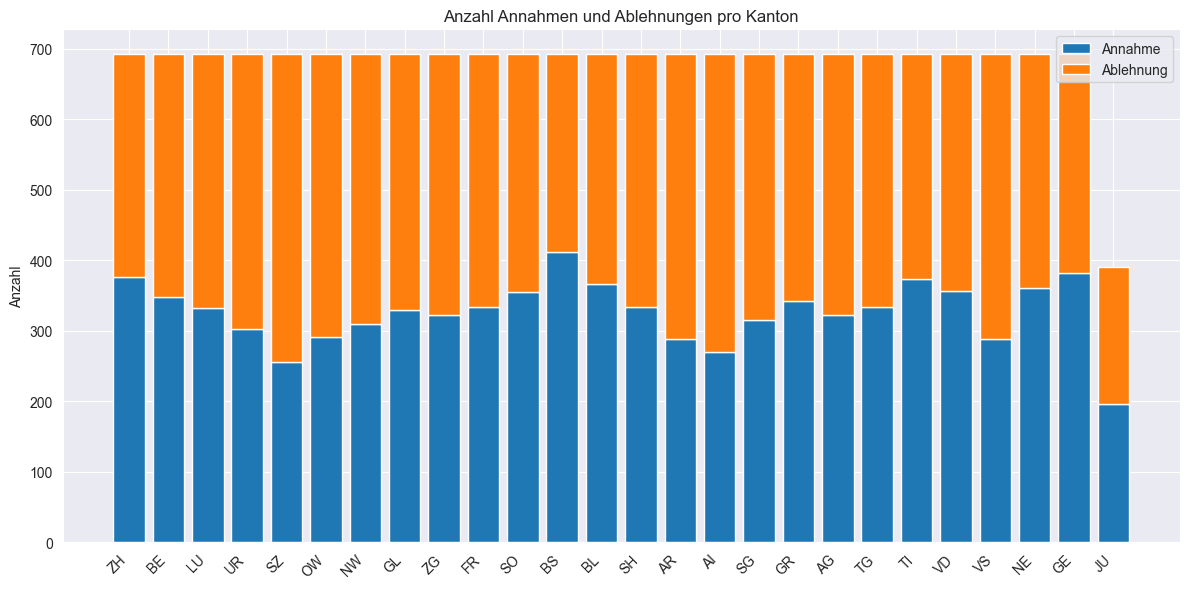

In [132]:
# Berechnung der Anzahl Annahmen und Ablehnungen pro Kanton
acceptance_counts = (df_filtered == 1).sum()  # Summe aller Annahmen
rejected_counts = (df_filtered == 0).sum()    # Summe aller Ablehnungen

# Formatiere die Kantonsnamen für die Visualisierung
# Ersetze "-annahme" und wandle in Großbuchstaben um (z.B. "zh-annahme" wird zu "ZH")
canton_names = acceptance_counts.index.str.replace("-annahme", "", regex=False).str.upper()

# Erstelle ein gestapeltes Balkendiagramm für Annahmen und Ablehnungen pro Kanton
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(canton_names, acceptance_counts.values, label='Annahme', color='tab:blue')
ax.bar(canton_names, rejected_counts.values, bottom=acceptance_counts.values, label='Ablehnung', color='tab:orange')

plt.xticks(rotation=45, ha='right')  # Drehe Beschriftungen für bessere Lesbarkeit
plt.title('Anzahl Annahmen und Ablehnungen pro Kanton')
plt.ylabel('Anzahl')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Erweiterte Analyse: Annahmequote pro Kanton

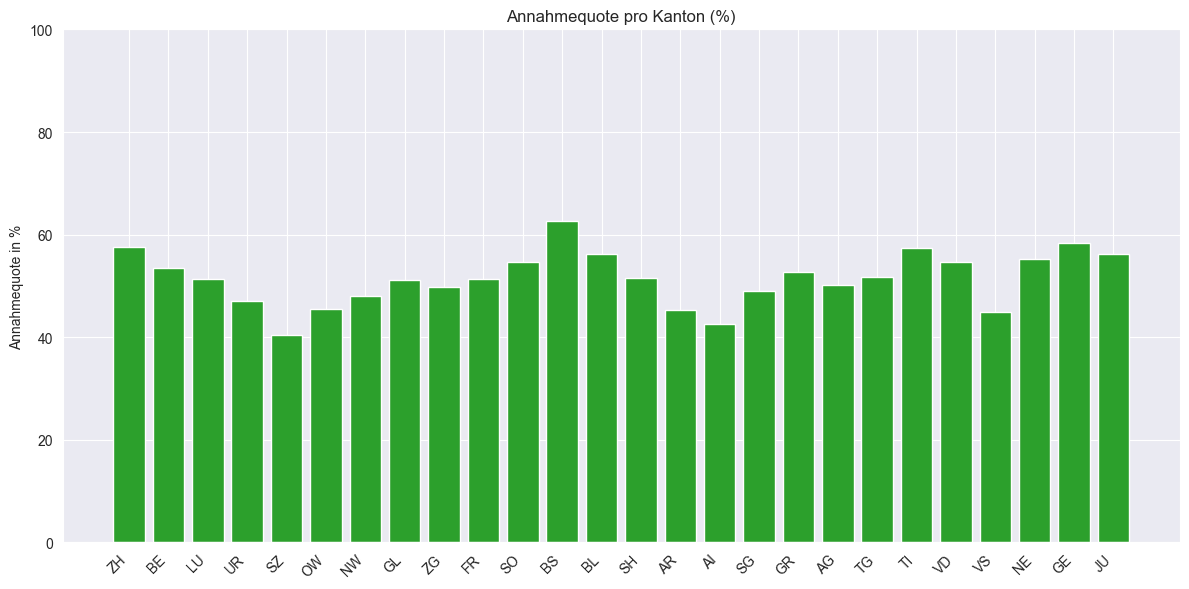

In [133]:
## 4. Erweiterte Analyse: Annahmequote pro Kanton
# Berechne die durchschnittliche Annahmequote pro Kanton
# Da die Werte 0 und 1 sind, gibt der Mittelwert direkt den Anteil der Annahmen an
acceptance_rate = df_filtered.mean()

# Visualisierung der Annahmequote als Prozentsatz in einem Balkendiagramm
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(canton_names, acceptance_rate.values * 100, color='tab:green')  # Umrechnung in Prozent
plt.xticks(rotation=45, ha='right')
plt.title('Annahmequote pro Kanton (%)')
plt.ylabel('Annahmequote in %')
plt.ylim(0, 100)  # Y-Achse von 0 bis 100%
plt.tight_layout()
plt.show()

## 5. Erweiterte Analyse: Korrelationsmatrix zwischen Kantonen


### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton

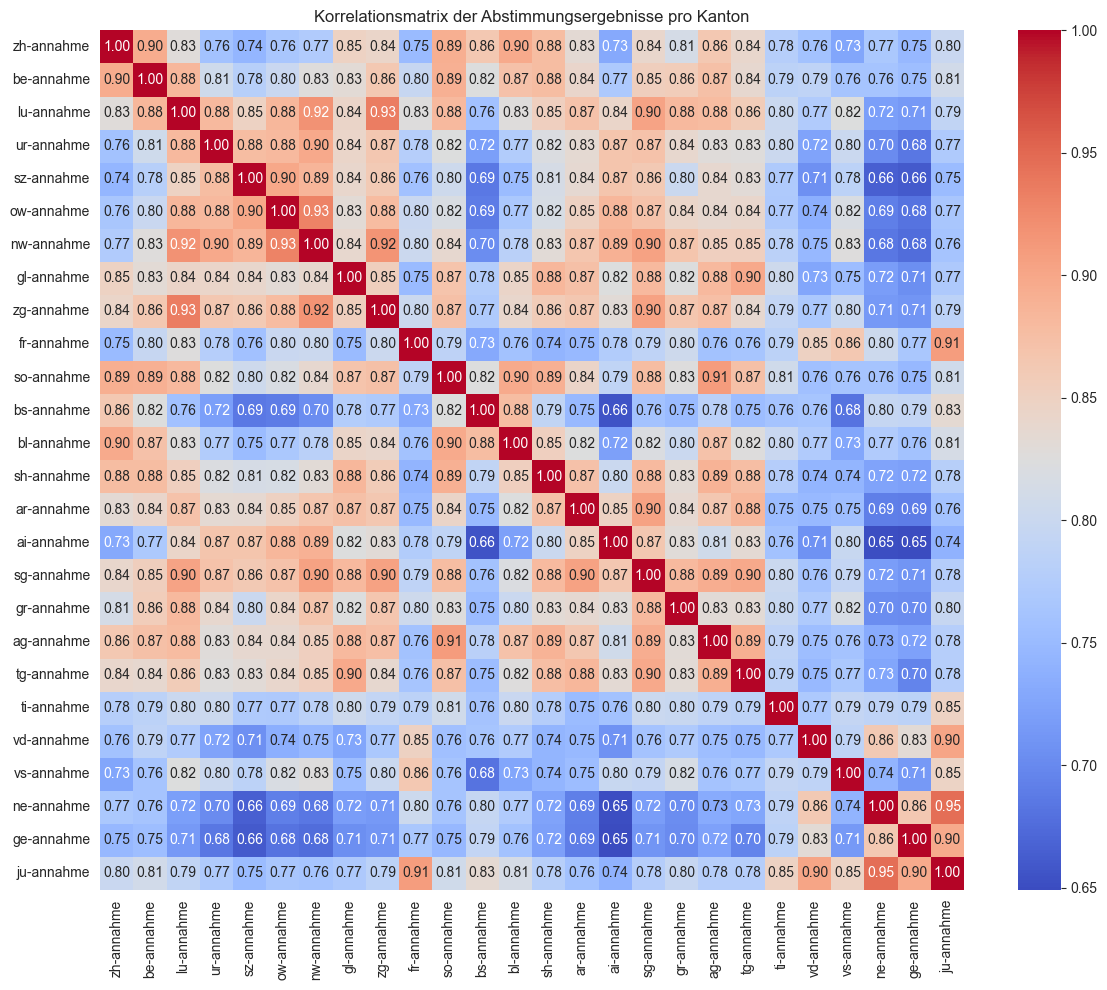

In [134]:
# Berechne Korrelationen zwischen Kantonen, um zu sehen, ob sie ähnlich abstimmen
# Positive Korrelation bedeutet, dass Kantone tendenziell ähnlich abstimmen
corr_matrix = df_filtered.corr()

# Visualisierung der Korrelationsmatrix als Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton")
plt.tight_layout()
plt.show()

### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton vor 1971

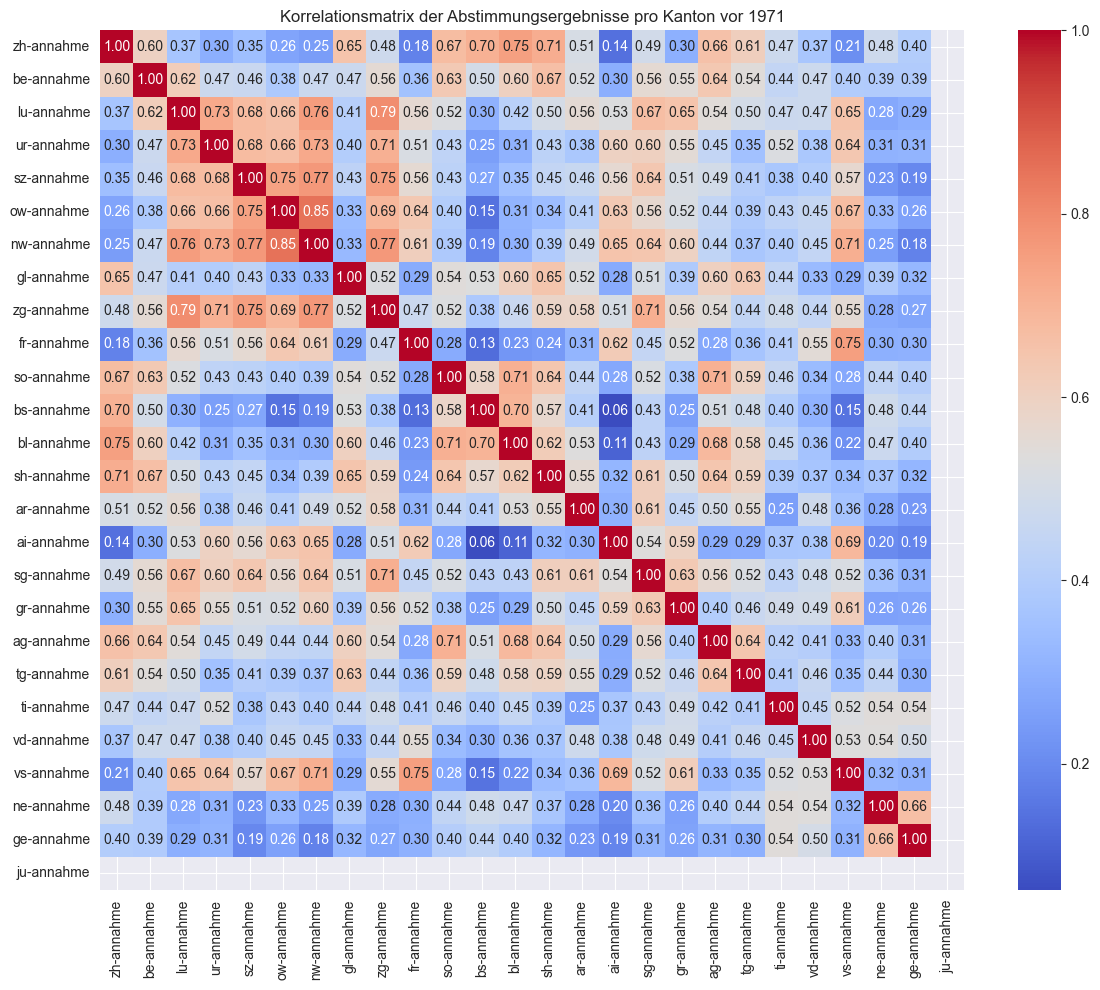

In [135]:
# Definiere das Datum für die Einführung des Frauenstimmrechts in der Schweiz
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_without_women = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_without_women.reset_index(drop=True, inplace=True)

# Berechne und visualisiere die Korrelationsmatrix für Abstimmungen vor 1971
corr_matrix = df_without_women.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton vor 1971")
plt.tight_layout()
plt.show()

### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton nach 1971

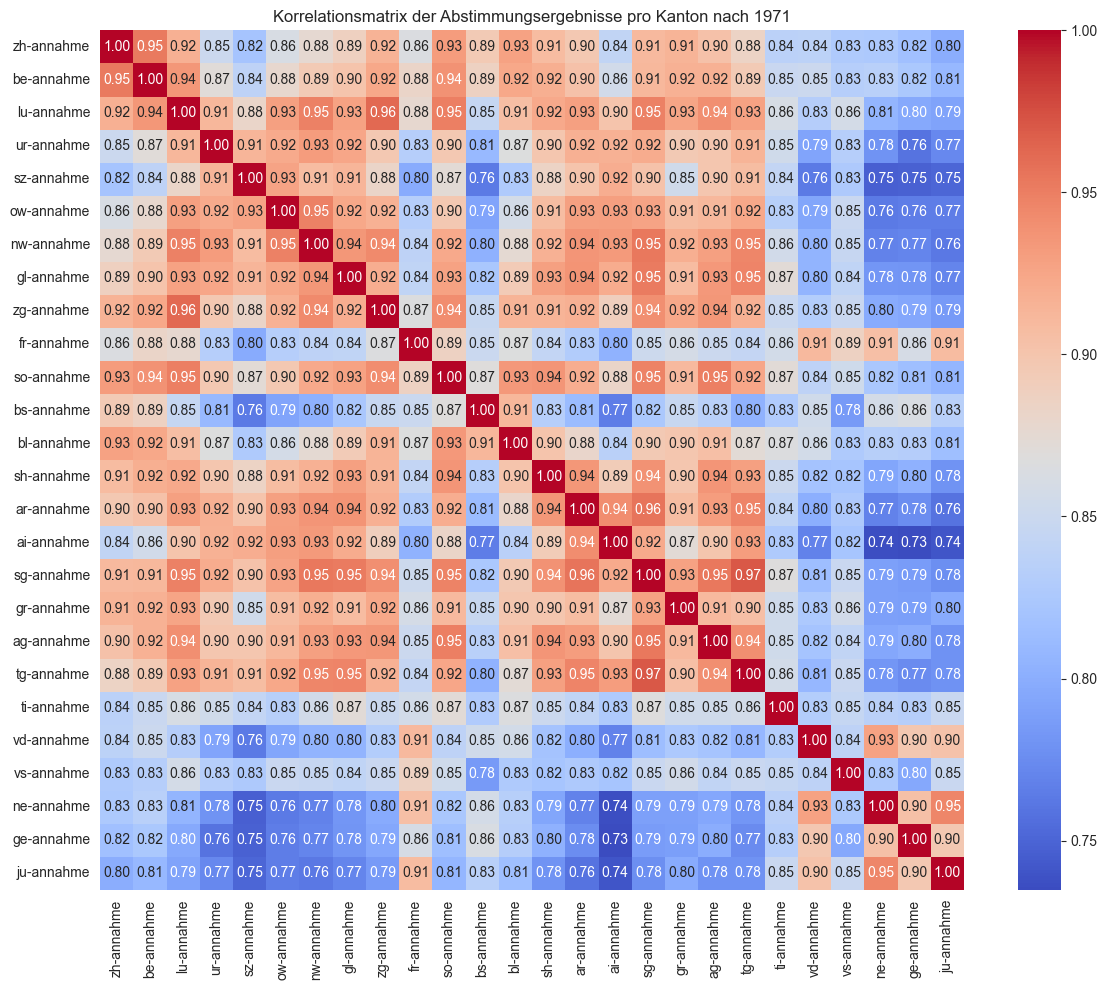

In [136]:
# Abstimmungen nach 1971 (mit Frauenstimmrecht)
df_with_women = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') > init_date]
df_with_women.reset_index(drop=True, inplace=True)

# Berechne und visualisiere die Korrelationsmatrix für Abstimmungen nach 1971
corr_matrix = df_with_women.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton nach 1971")
plt.tight_layout()
plt.show()

Date range in data: 1848-09-12 00:00:00 to 2025-02-09 00:00:00
Number of votes before 1971: 228
Number of votes after 1971: 468
Creating correlation matrices...


/var/folders/sc/hk55c1v54g3dff0094vmwkb80000gn/T/ipykernel_5675/2292337349.py:86: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/sc/hk55c1v54g3dff0094vmwkb80000gn/T/ipykernel_5675/2292337349.py:87: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`




Correlation differences:
AG: 0.2031
AI: 0.2526
AR: 0.2588
BE: 0.1850
BL: 0.2352
BS: 0.2501
FR: 0.2765
GE: 0.2291
GL: 0.2575
GR: 0.2550
JU: 0.0086
LU: 0.2033
NE: 0.2757
NW: 0.2282
OW: 0.2435
SG: 0.1650
SH: 0.2369
SO: 0.2241
SZ: 0.1936
TG: 0.2494
TI: 0.2016
UR: 0.2410
VD: 0.2233
VS: 0.2012
ZG: 0.1842
ZH: 0.3073
Error downloading shapefile: name 'zipfile' is not defined


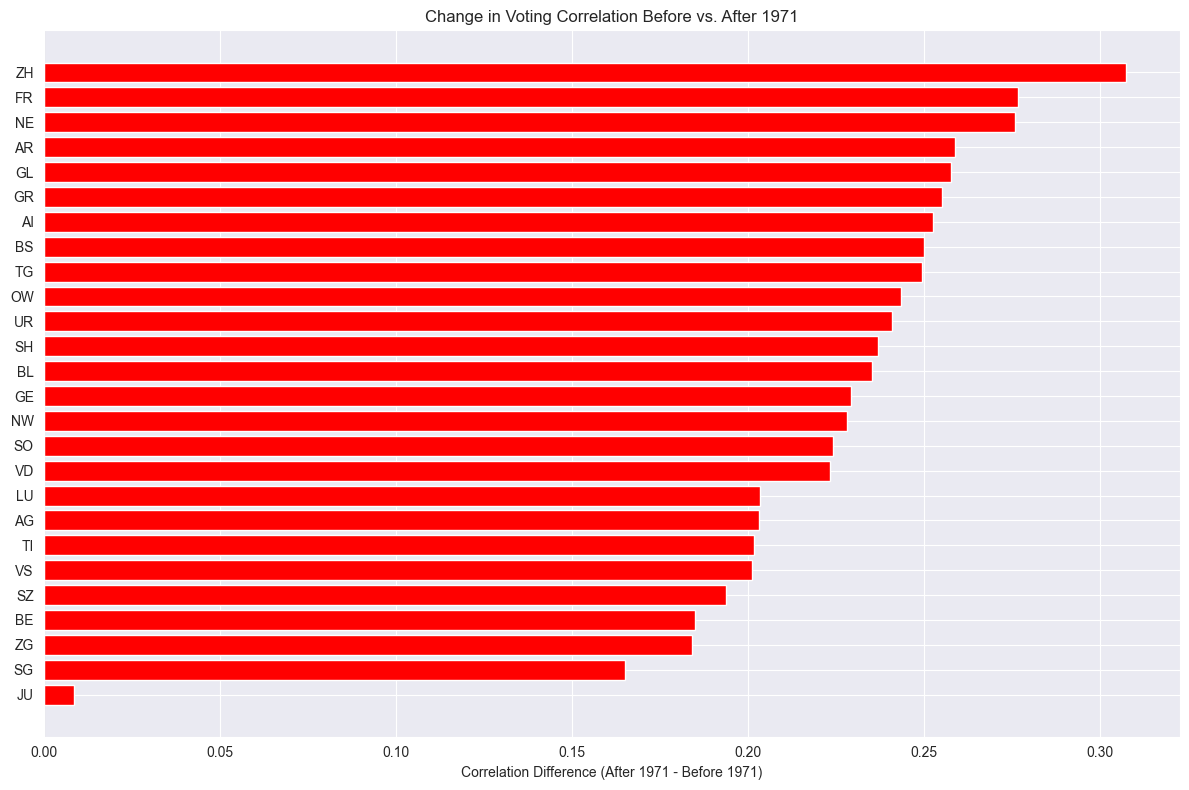

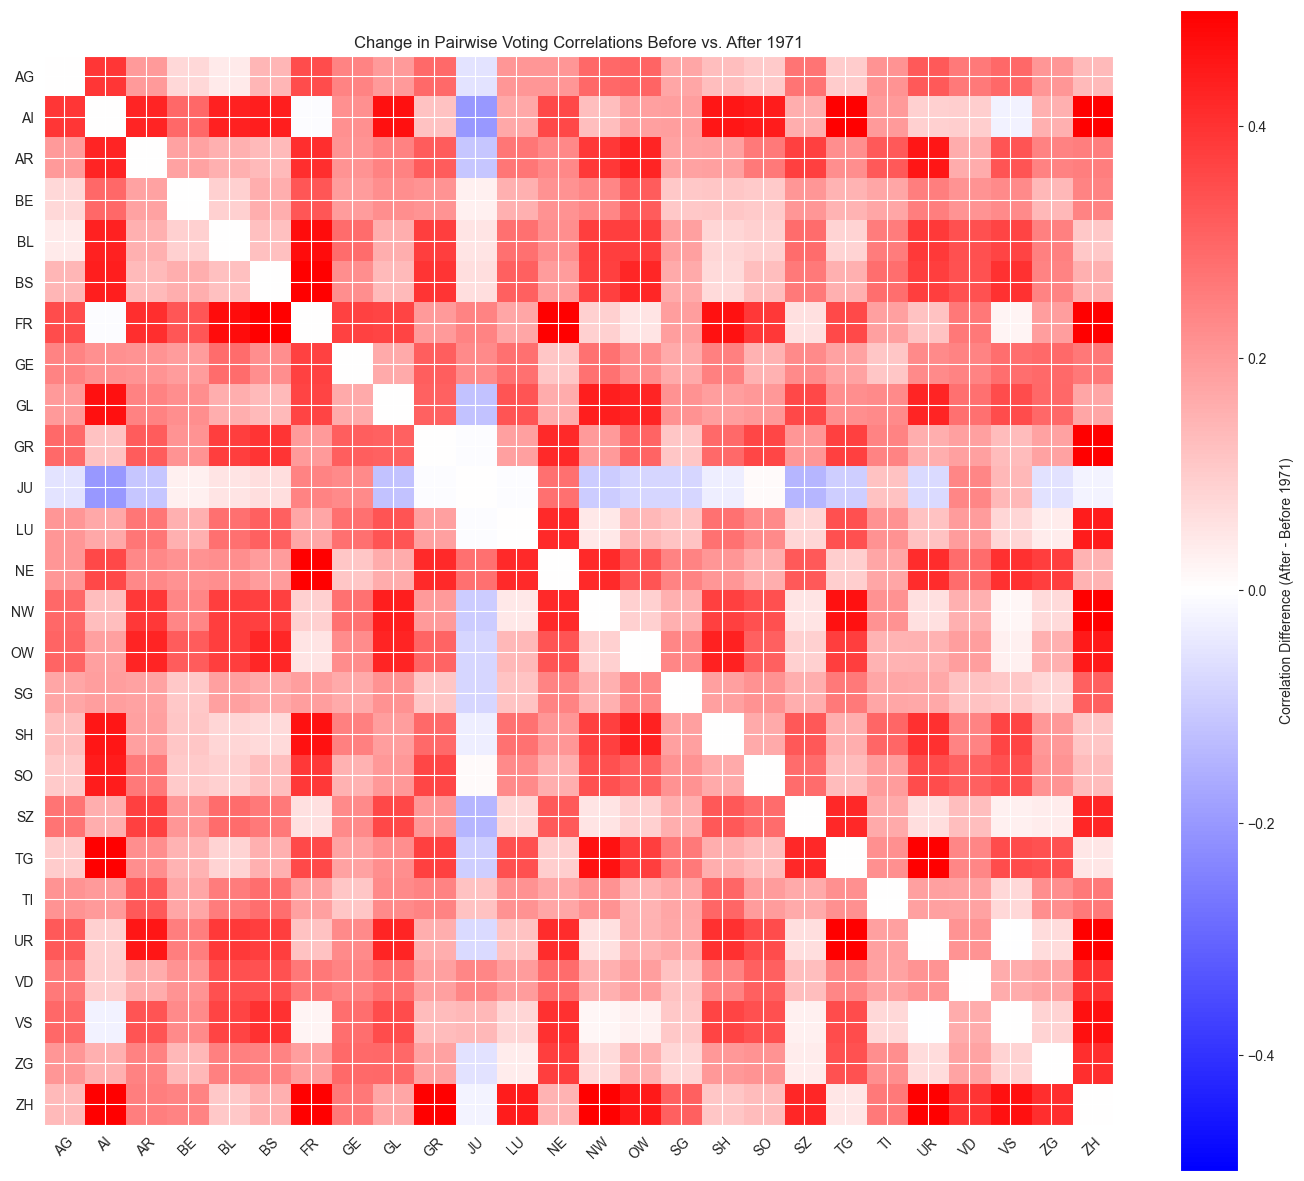


Summary statistics of correlation differences:
Mean difference: 0.2227
Median difference: 0.2322
Min difference: 0.0086 (Canton: JU)
Max difference: 0.3073 (Canton: ZH)
Standard deviation: 0.0535

Cantons with increased correlation after 1971: 26 (100.0%)
Cantons with decreased correlation after 1971: 0 (0.0%)


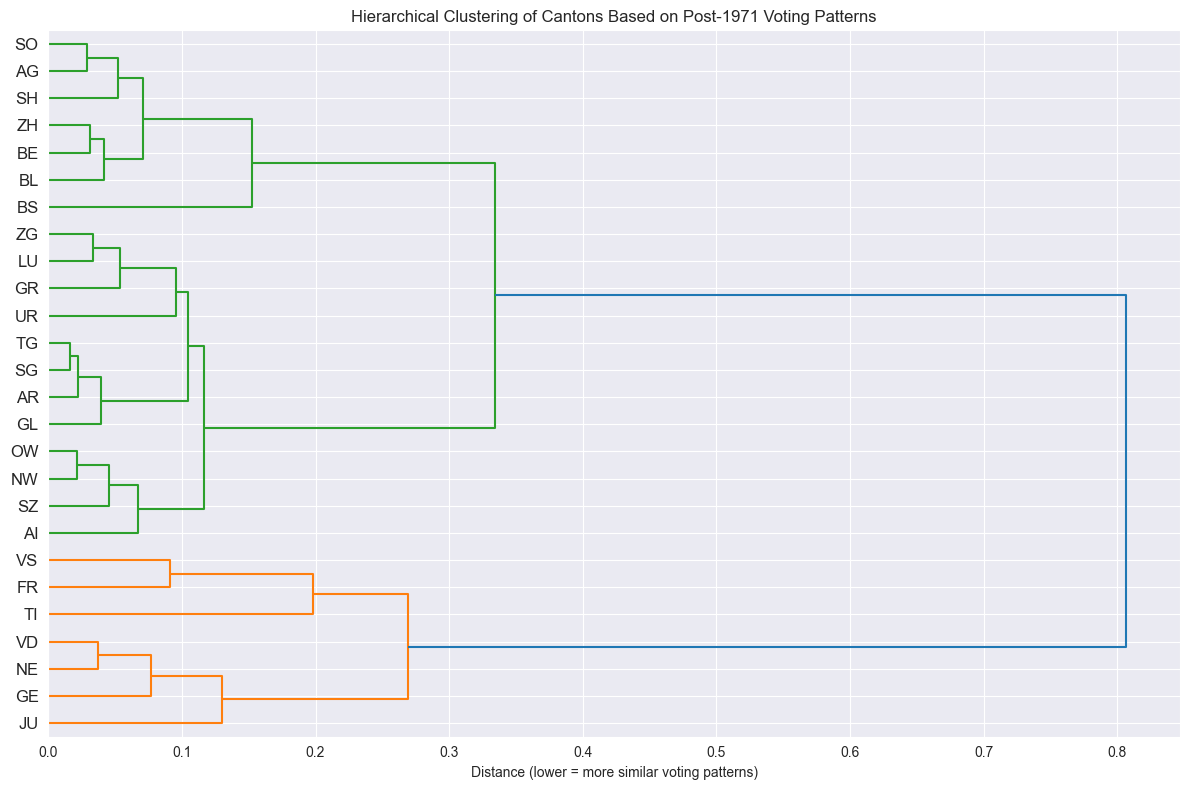

In [137]:
# ========================= PART 1: DATA PREPARATION =========================
# Read your data
df = pd.read_csv("Data/dataset.csv", sep=";")  # Adjust path as needed

# Convert date strings to datetime objects
df['date'] = pd.to_datetime(df['datum'], format='%d.%m.%Y', errors='coerce')
print(f"Date range in data: {df['date'].min()} to {df['date'].max()}")

# Split data before and after women's suffrage (February 7, 1971)
init_date = datetime(1971, 2, 7)
df_before_1971 = df[df['date'] < init_date].copy()
df_after_1971 = df[df['date'] >= init_date].copy()

print(f"Number of votes before 1971: {len(df_before_1971)}")
print(f"Number of votes after 1971: {len(df_after_1971)}")

# List of canton codes
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
               'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
               'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Verify that canton columns exist in the dataframe
for canton in canton_codes:
    col_name = f"{canton.lower()}-japroz"
    if col_name not in df.columns:
        print(f"Warning: Column {col_name} not found in dataframe")

# ================= PART 2: CORRELATION CALCULATION =================
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Convert to numeric, coercing errors to NaN
                votes1 = pd.to_numeric(data[canton1_col], errors='coerce').dropna()
                votes2 = pd.to_numeric(data[canton2_col], errors='coerce').dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
print("Creating correlation matrices...")
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    print("Removing Jura from pre-1971 correlation matrix (didn't exist yet)")
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Print the correlation differences
print("\nCorrelation differences:")
for canton, diff in sorted(corr_diff.items()):
    print(f"{canton}: {diff:.4f}")

# ================= PART 4: ALTERNATIVE VISUALIZATIONS =================
# 1. Bar chart of correlation differences
plt.figure(figsize=(12, 8))
cantons = list(corr_diff.keys())
values = list(corr_diff.values())

# Sort by correlation difference
sorted_indices = np.argsort(values)
sorted_cantons = [cantons[i] for i in sorted_indices]
sorted_values = [values[i] for i in sorted_indices]

# Create color mapping
colors = ['blue' if v < 0 else 'red' for v in sorted_values]

plt.barh(sorted_cantons, sorted_values, color=colors)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Change in Voting Correlation Before vs. After 1971')
plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
plt.tight_layout()
plt.show()
# 2. Heatmap of correlation differences
plt.figure(figsize=(14, 12))
diff_matrix = corr_after - corr_before

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)

# Plot the heatmap
im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
plt.colorbar(im, label='Correlation Difference (After - Before 1971)')

# Add canton labels
plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)

plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
plt.tight_layout()
plt.show()

# 3. Print summary statistics
print("\nSummary statistics of correlation differences:")
diff_values = np.array(list(corr_diff.values()))
print(f"Mean difference: {diff_values.mean():.4f}")
print(f"Median difference: {np.median(diff_values):.4f}")
print(f"Min difference: {diff_values.min():.4f} (Canton: {cantons[np.argmin(diff_values)]})")
print(f"Max difference: {diff_values.max():.4f} (Canton: {cantons[np.argmax(diff_values)]})")
print(f"Standard deviation: {diff_values.std():.4f}")

# Count how many cantons had increased or decreased correlations
increased = sum(1 for v in diff_values if v > 0)
decreased = sum(1 for v in diff_values if v < 0)
print(f"\nCantons with increased correlation after 1971: {increased} ({increased/len(diff_values)*100:.1f}%)")
print(f"Cantons with decreased correlation after 1971: {decreased} ({decreased/len(diff_values)*100:.1f}%)")

# Optional: Cluster analysis to identify groups of similar cantons
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Convert correlation matrix to distance matrix (higher correlation = shorter distance)
distance_matrix = 1 - corr_after
# Convert to condensed form for linkage
condensed_dist = squareform(distance_matrix)

# Perform hierarchical clustering
Z = linkage(condensed_dist, 'ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(
    Z,
    labels=corr_after.index,
    orientation='right',
    leaf_font_size=12
)
plt.title('Hierarchical Clustering of Cantons Based on Post-1971 Voting Patterns')
plt.xlabel('Distance (lower = more similar voting patterns)')
plt.tight_layout()
plt.show()



Average correlations before 1971:
SG: 0.7194
BE: 0.6965
ZG: 0.6926
LU: 0.6885
AG: 0.6817
SO: 0.6617
JU: 0.6417
BL: 0.6414
SZ: 0.6367
SH: 0.6366
NW: 0.6358
GR: 0.6252
TG: 0.6228
AR: 0.6086
OW: 0.6086
GL: 0.6045
UR: 0.5979
TI: 0.5929
VS: 0.5870
FR: 0.5755
ZH: 0.5659
AI: 0.5584
VD: 0.5555
BS: 0.5472
GE: 0.4977
NE: 0.4870


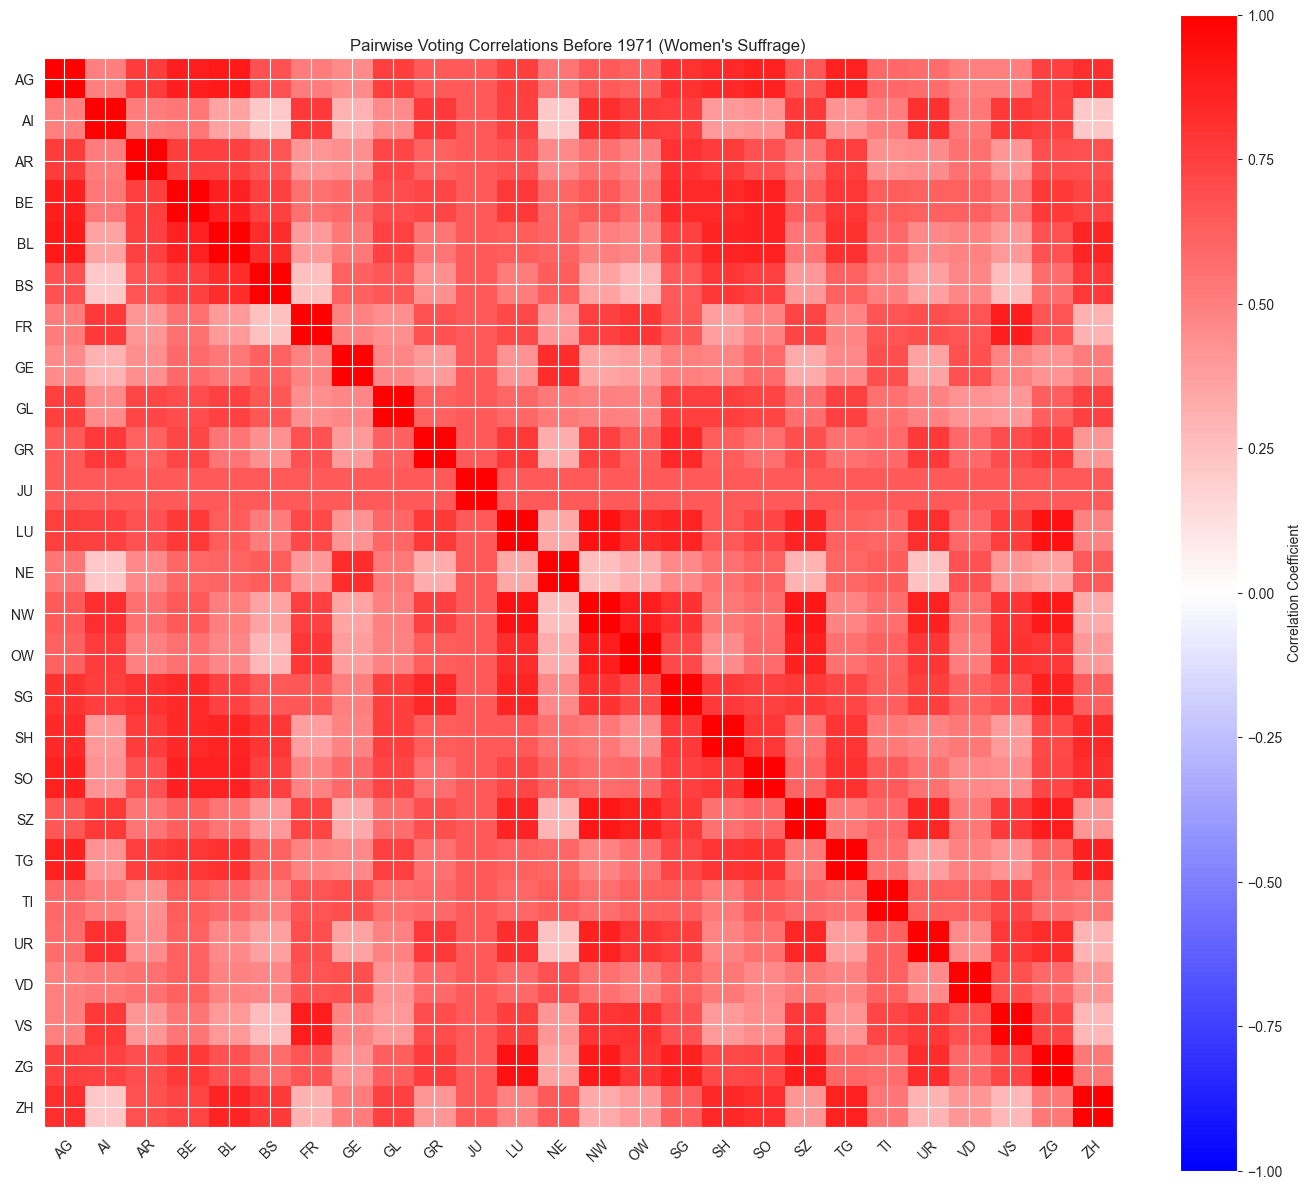

/var/folders/sc/hk55c1v54g3dff0094vmwkb80000gn/T/ipykernel_5675/1195349198.py:106: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



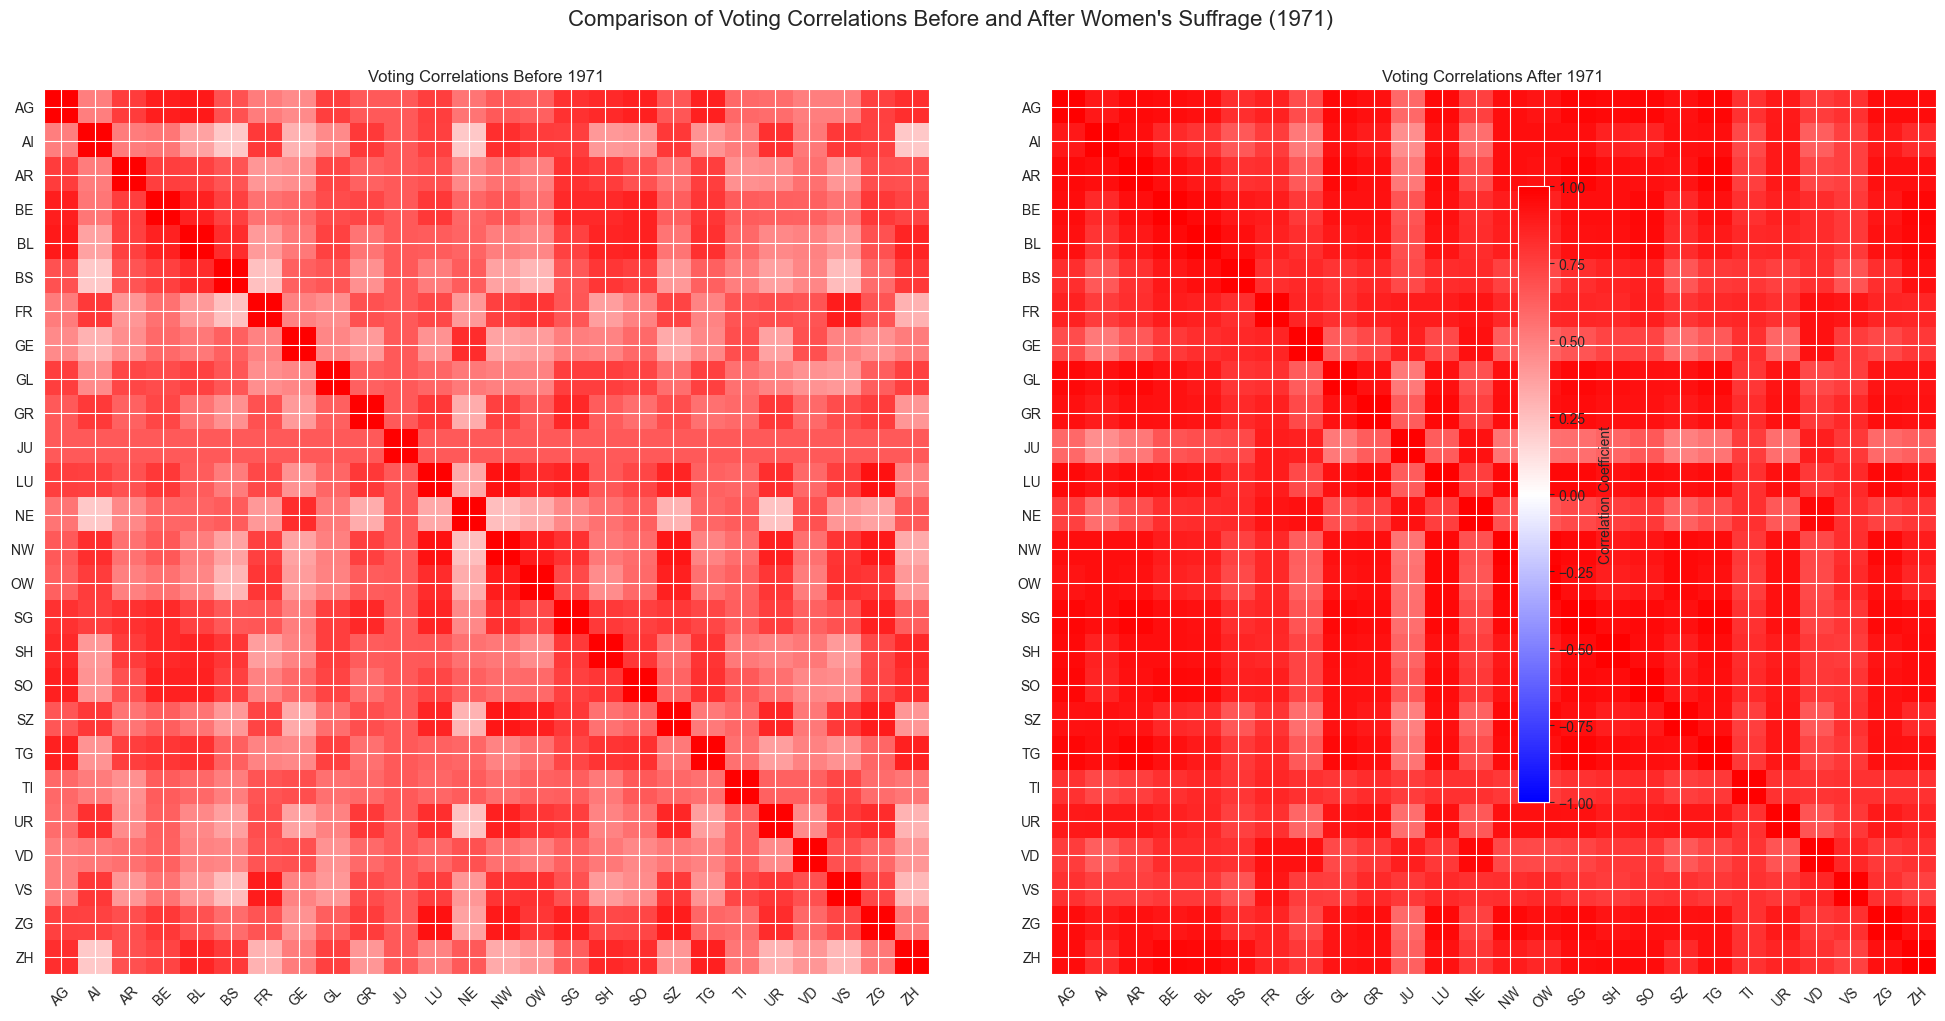

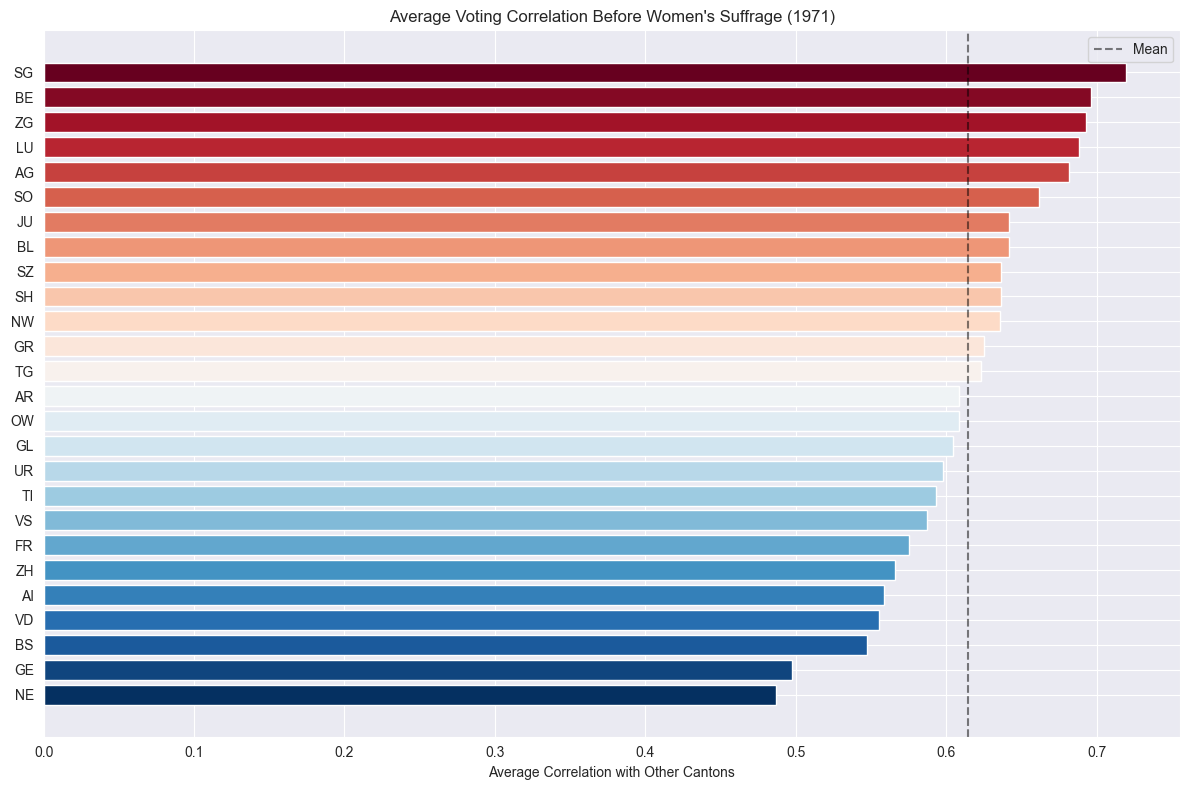

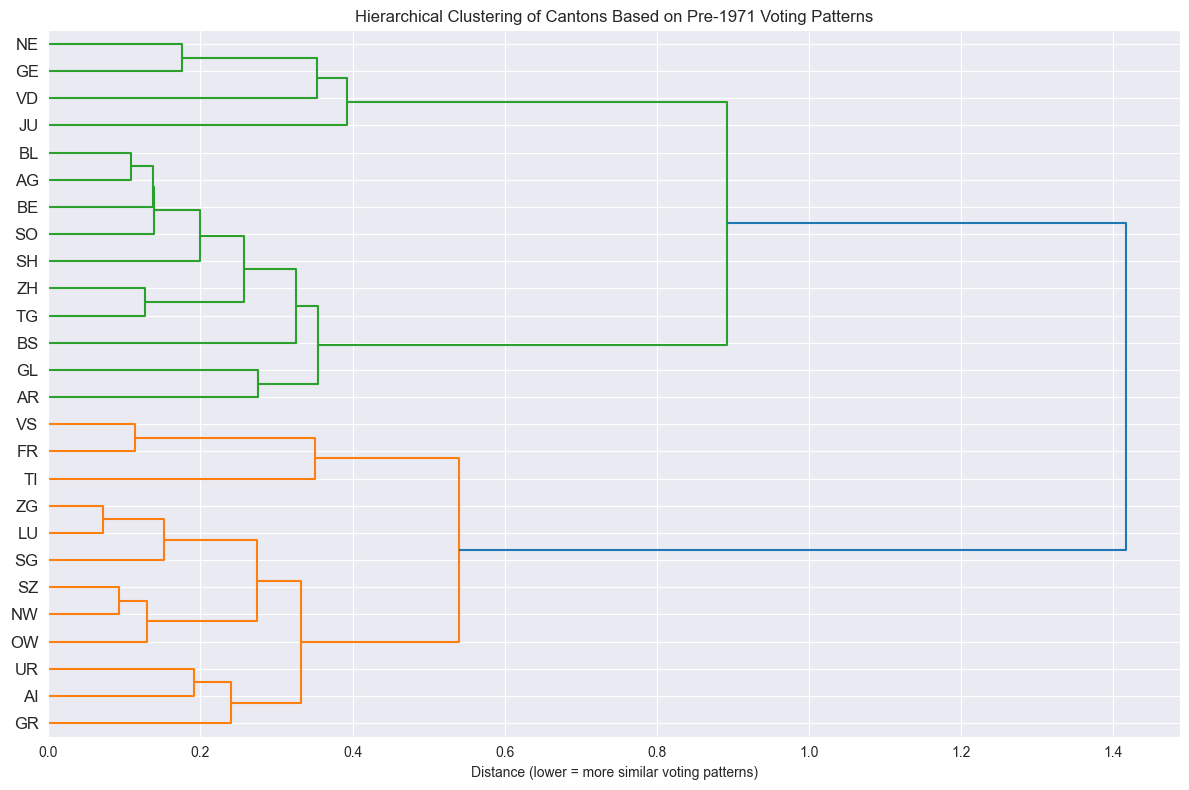

In [138]:
# After your existing correlation analysis section, add these visualizations for before 1971

# ================= PART 3.5: VISUALIZE PRE-1971 CORRELATIONS =================
# Calculate average correlation for each canton before 1971
avg_corr_before = {}
for canton in corr_before.index:
    # Calculate average correlation with other cantons (excluding self-correlation)
    avg_corr_before[canton] = corr_before.loc[canton].drop(canton).mean()

# Print average correlations before 1971
print("\nAverage correlations before 1971:")
for canton, corr in sorted(avg_corr_before.items(), key=lambda x: x[1], reverse=True):
    print(f"{canton}: {corr:.4f}")
# 2. Heatmap of pre-1971 correlations
plt.figure(figsize=(14, 12))

# Create a custom colormap for correlations
corr_cmap = LinearSegmentedColormap.from_list('corr_cmap', ['blue', 'white', 'red'], N=256)

# Plot the heatmap
im = plt.imshow(corr_before, cmap=corr_cmap, vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation Coefficient')

# Add canton labels
plt.xticks(range(len(corr_before.columns)), corr_before.columns, rotation=45)
plt.yticks(range(len(corr_before.index)), corr_before.index)

plt.title('Pairwise Voting Correlations Before 1971 (Women\'s Suffrage)')
plt.tight_layout()
plt.show()

# 3. Side by side comparison of before and after correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Before 1971
im1 = ax1.imshow(corr_before, cmap=corr_cmap, vmin=-1, vmax=1)
ax1.set_title('Voting Correlations Before 1971')
ax1.set_xticks(range(len(corr_before.columns)))
ax1.set_yticks(range(len(corr_before.index)))
ax1.set_xticklabels(corr_before.columns, rotation=45)
ax1.set_yticklabels(corr_before.index)

# After 1971
im2 = ax2.imshow(corr_after, cmap=corr_cmap, vmin=-1, vmax=1)
ax2.set_title('Voting Correlations After 1971')
ax2.set_xticks(range(len(corr_after.columns)))
ax2.set_yticks(range(len(corr_after.index)))
ax2.set_xticklabels(corr_after.columns, rotation=45)
ax2.set_yticklabels(corr_after.index)

# Add a colorbar
cbar = fig.colorbar(im1, ax=[ax1, ax2], shrink=0.8, label='Correlation Coefficient')

plt.tight_layout()
plt.suptitle('Comparison of Voting Correlations Before and After Women\'s Suffrage (1971)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# 4. Bar chart of average correlations before 1971
plt.figure(figsize=(12, 8))
cantons_before = list(avg_corr_before.keys())
values_before = list(avg_corr_before.values())

# Sort by correlation
sorted_indices = np.argsort(values_before)
sorted_cantons = [cantons_before[i] for i in sorted_indices]
sorted_values = [values_before[i] for i in sorted_indices]

# Create color gradient based on correlation strength
colors = plt.cm.RdBu_r(np.linspace(0, 1, len(sorted_values)))

plt.barh(sorted_cantons, sorted_values, color=colors)
plt.axvline(x=np.mean(values_before), color='black', linestyle='--', alpha=0.5, label='Mean')
plt.title('Average Voting Correlation Before Women\'s Suffrage (1971)')
plt.xlabel('Average Correlation with Other Cantons')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Optional: Hierarchical clustering of cantons based on pre-1971 voting patterns
distance_matrix_before = 1 - corr_before
condensed_dist_before = squareform(distance_matrix_before)

Z_before = linkage(condensed_dist_before, 'ward')

plt.figure(figsize=(12, 8))
dendrogram(
    Z_before,
    labels=corr_before.index,
    orientation='right',
    leaf_font_size=12
)
plt.title('Hierarchical Clustering of Cantons Based on Pre-1971 Voting Patterns')
plt.xlabel('Distance (lower = more similar voting patterns)')
plt.tight_layout()
plt.show()


Average correlations after 1971:
LU: 0.8918
SO: 0.8858
AG: 0.8848
SG: 0.8844
BE: 0.8815
GR: 0.8801
ZG: 0.8768
BL: 0.8766
SH: 0.8736
ZH: 0.8732
TG: 0.8723
AR: 0.8674
NW: 0.8640
GL: 0.8621
OW: 0.8520
FR: 0.8520
UR: 0.8390
SZ: 0.8303
AI: 0.8110
BS: 0.7973
TI: 0.7945
VS: 0.7882
VD: 0.7788
NE: 0.7627
GE: 0.7268
JU: 0.6503


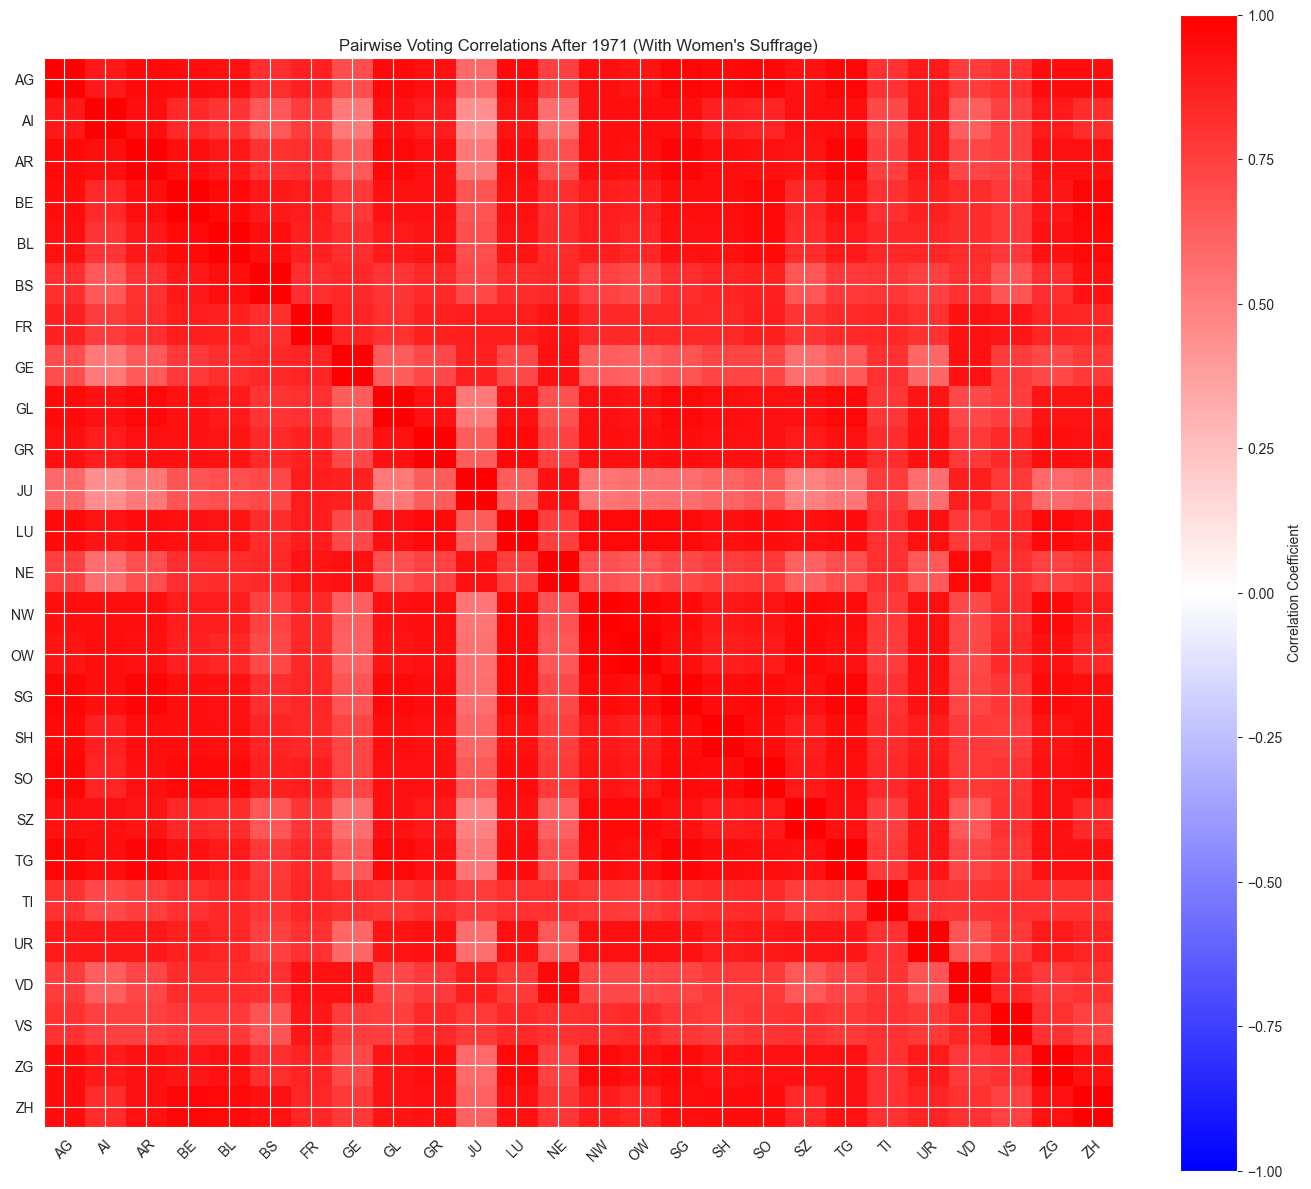

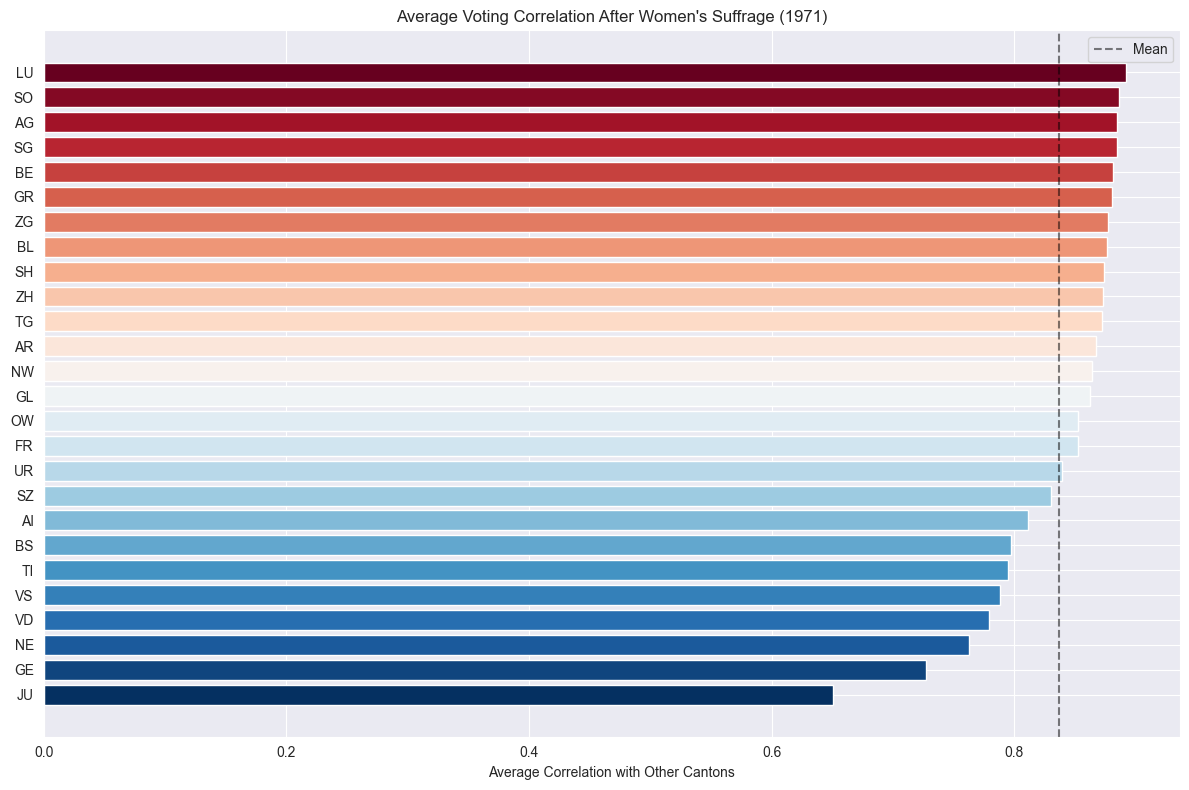

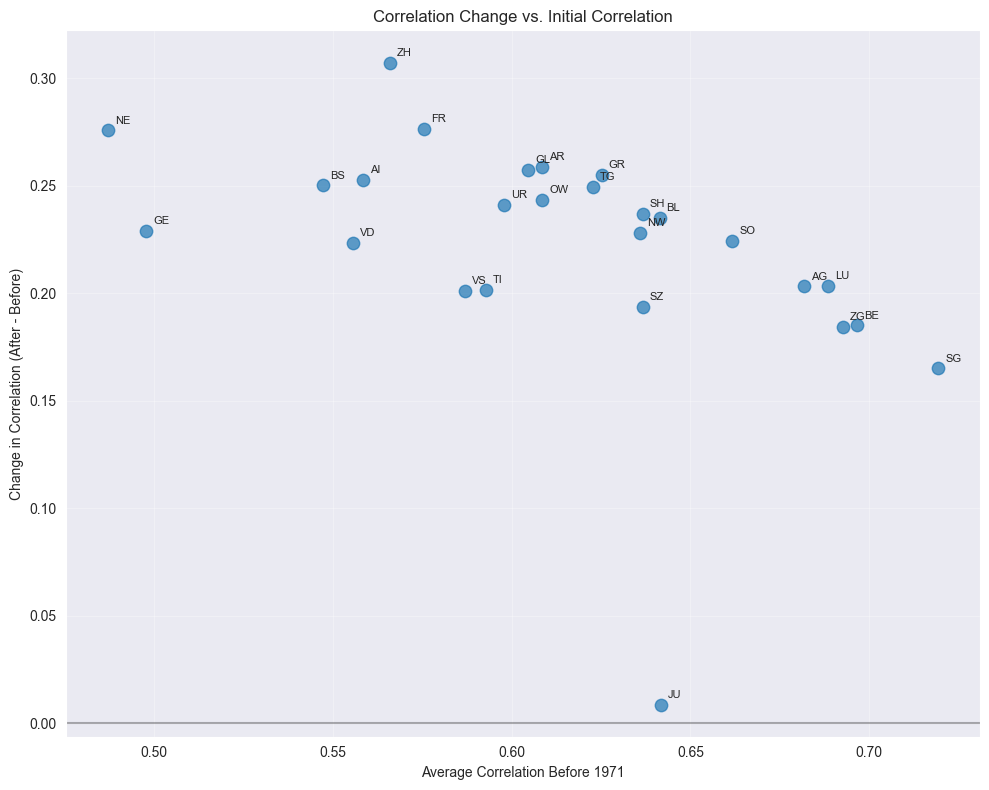

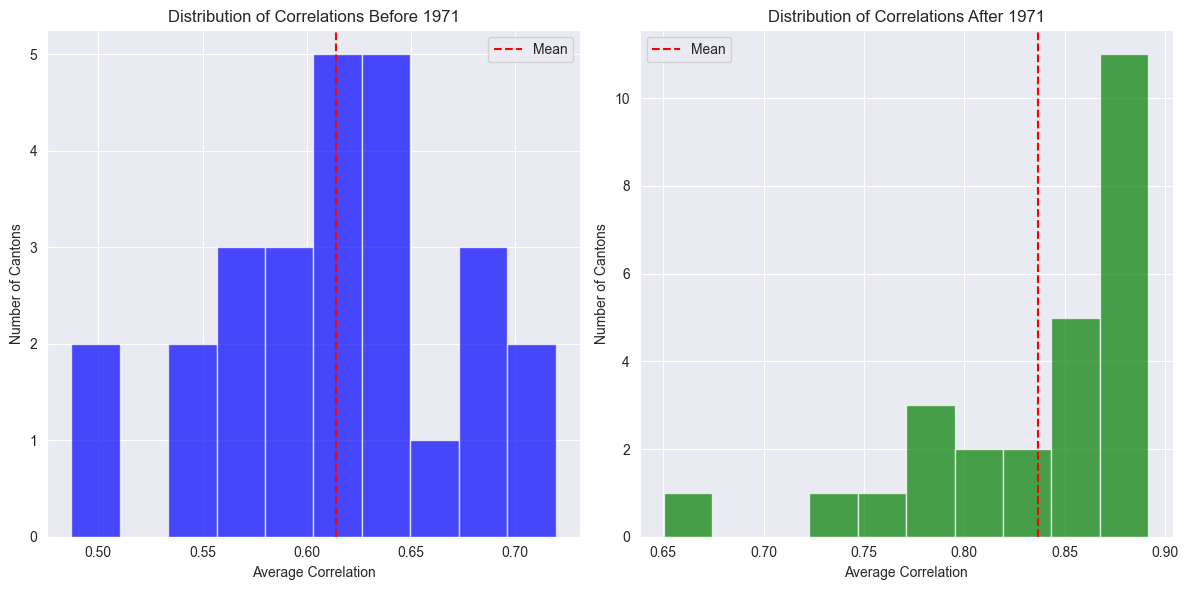

In [179]:
# ================= PART 3.6: VISUALIZE POST-1971 CORRELATIONS =================
# Calculate average correlation for each canton after 1971
avg_corr_after = {}
for canton in corr_after.index:
    # Calculate average correlation with other cantons (excluding self-correlation)
    avg_corr_after[canton] = corr_after.loc[canton].drop(canton).mean()

# Print average correlations after 1971
print("\nAverage correlations after 1971:")
for canton, corr in sorted(avg_corr_after.items(), key=lambda x: x[1], reverse=True):
    print(f"{canton}: {corr:.4f}")

# 2. Heatmap of post-1971 correlations
plt.figure(figsize=(14, 12))

# Create a custom colormap for correlations
corr_cmap = LinearSegmentedColormap.from_list('corr_cmap', ['blue', 'white', 'red'], N=256)

# Plot the heatmap
im = plt.imshow(corr_after, cmap=corr_cmap, vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation Coefficient')

# Add canton labels
plt.xticks(range(len(corr_after.columns)), corr_after.columns, rotation=45)
plt.yticks(range(len(corr_after.index)), corr_after.index)

plt.title('Pairwise Voting Correlations After 1971 (With Women\'s Suffrage)')
plt.tight_layout()
plt.show()

# 3. Bar chart of average correlations after 1971
plt.figure(figsize=(12, 8))
cantons_after = list(avg_corr_after.keys())
values_after = list(avg_corr_after.values())

# Sort by correlation
sorted_indices = np.argsort(values_after)
sorted_cantons = [cantons_after[i] for i in sorted_indices]
sorted_values = [values_after[i] for i in sorted_indices]

# Create color gradient based on correlation strength
colors = plt.cm.RdBu_r(np.linspace(0, 1, len(sorted_values)))

plt.barh(sorted_cantons, sorted_values, color=colors)
plt.axvline(x=np.mean(values_after), color='black', linestyle='--', alpha=0.5, label='Mean')
plt.title('Average Voting Correlation After Women\'s Suffrage (1971)')
plt.xlabel('Average Correlation with Other Cantons')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Correlation change vs. initial correlation
plt.figure(figsize=(10, 8))
x_vals = []
y_vals = []
labels = []

for canton in corr_diff.keys():
    if canton in avg_corr_before and canton in avg_corr_after:
        x_vals.append(avg_corr_before[canton])
        y_vals.append(corr_diff[canton])
        labels.append(canton)

plt.scatter(x_vals, y_vals, s=80, alpha=0.7)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add canton labels to each point
for i, label in enumerate(labels):
    plt.annotate(label, (x_vals[i], y_vals[i]), fontsize=8, 
                 xytext=(5, 5), textcoords='offset points')

plt.title('Correlation Change vs. Initial Correlation')
plt.xlabel('Average Correlation Before 1971')
plt.ylabel('Change in Correlation (After - Before)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Show the change in correlation distribution
plt.figure(figsize=(12, 6))

# Create data for the plots
before_values = list(avg_corr_before.values())
after_values = [avg_corr_after[c] for c in avg_corr_before.keys()]  # Maintain same order

plt.subplot(1, 2, 1)
plt.hist(before_values, bins=10, alpha=0.7, color='blue')
plt.axvline(x=np.mean(before_values), color='red', linestyle='--', label='Mean')
plt.title('Distribution of Correlations Before 1971')
plt.xlabel('Average Correlation')
plt.ylabel('Number of Cantons')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(after_values, bins=10, alpha=0.7, color='green')
plt.axvline(x=np.mean(after_values), color='red', linestyle='--', label='Mean')
plt.title('Distribution of Correlations After 1971')
plt.xlabel('Average Correlation')
plt.ylabel('Number of Cantons')
plt.legend()

plt.tight_layout()
plt.show()

## Korrelationsmatrix besser veranschaulichen
Da wir die Korrelationen nun ausgerechnet haben stellt sich die Frage, ob gewisse Kantone Ähnlichkeit mit anderen aufweisen,
diese sich aufgrund ähnlicher Kultur oder geografischer Proximität beinflusst haben. Deshalb probieren wir die Korrelation anhand
einer 2D Abbildung mit Punkten darzustellen.

### Cluster vor 1971

NaN values detected in the matrix! Replacing NaNs with 0.


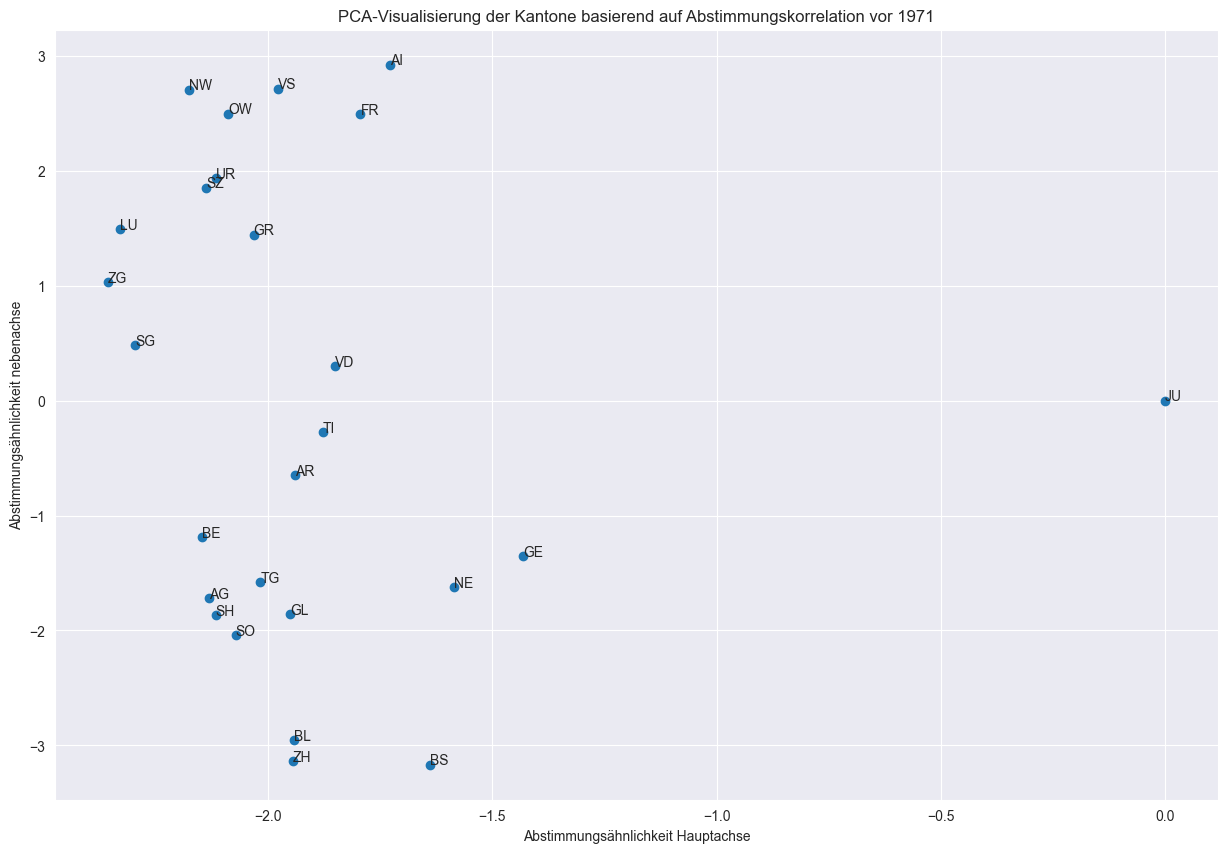

In [183]:
corr_matrix = df_without_women.corr()

if corr_matrix.isna().sum().sum() > 0:
    print("NaN values detected in the matrix! Replacing NaNs with 0.")
    corr_matrix = corr_matrix.fillna(0)  # Replace NaNs with 0 to avoid errors


# Perform PCA using numpy (Eigen decomposition)
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)
pca_coords = eigenvectors[:, :2] * 10

# Scatterplot of cantons based on their correlation similarity
plt.figure(figsize=(15, 10))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1])

# Annotate points with canton names
for i, canton in enumerate(corr_matrix.index):
    plt.annotate(canton.upper().replace("-ANNAHME", ""), (pca_coords[i, 0], pca_coords[i, 1]), fontsize=10)

plt.title("PCA-Visualisierung der Kantone basierend auf Abstimmungskorrelation vor 1971")
plt.xlabel("Abstimmungsähnlichkeit Hauptachse")
plt.ylabel("Abstimmungsähnlichkeit nebenachse")
plt.grid(True)
plt.show()

### Cluster nach 1971

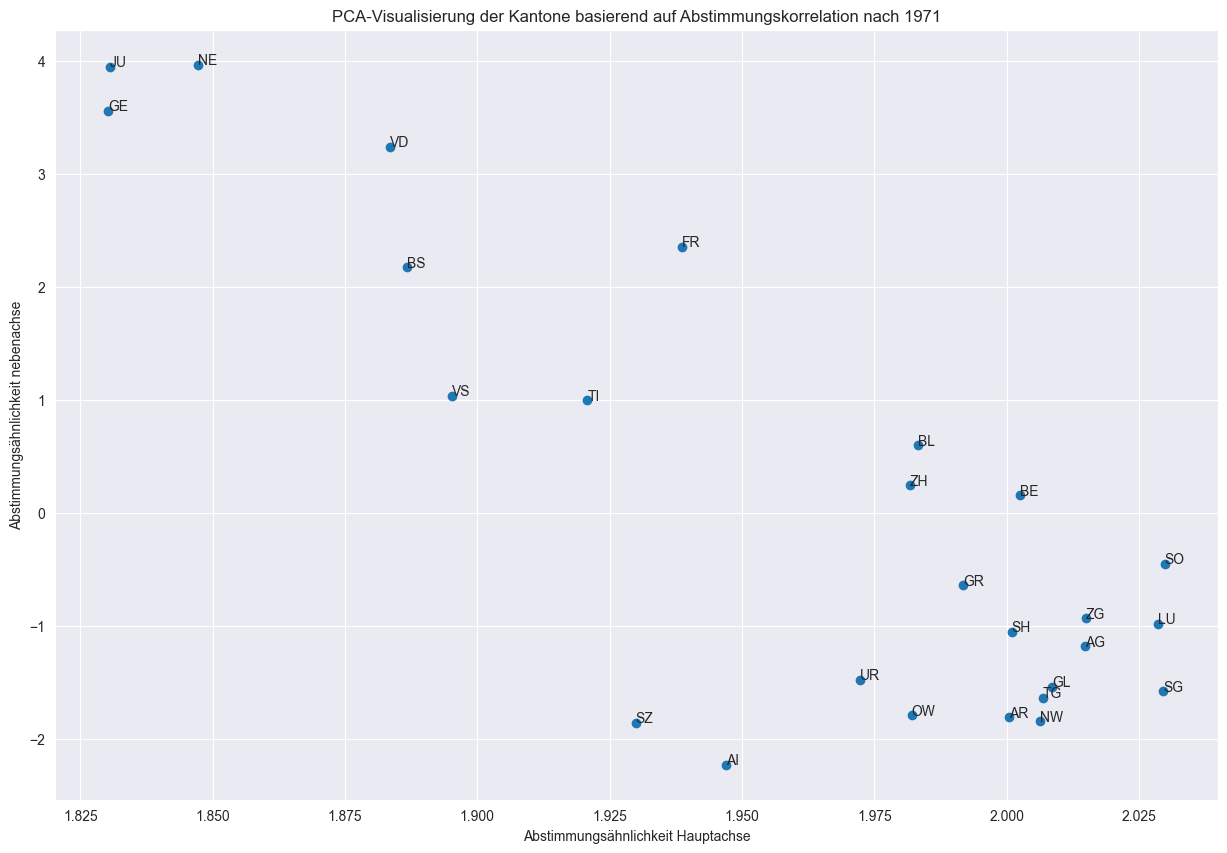

In [182]:
corr_matrix = df_with_women.corr()

if corr_matrix.isna().sum().sum() > 0:
    print("NaN values detected in the matrix! Replacing NaNs with 0.")
    corr_matrix = corr_matrix.fillna(0)  # Replace NaNs with 0 to avoid errors


# Perform PCA using numpy (Eigen decomposition)
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)
pca_coords = eigenvectors[:, :2] * 10

# Scatterplot of cantons based on their correlation similarity
plt.figure(figsize=(15, 10))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1])

# Annotate points with canton names
for i, canton in enumerate(corr_matrix.index):
    plt.annotate(canton.upper().replace("-ANNAHME", ""), (pca_coords[i, 0], pca_coords[i, 1]), fontsize=10)

plt.title("PCA-Visualisierung der Kantone basierend auf Abstimmungskorrelation nach 1971")
plt.xlabel("Abstimmungsähnlichkeit Hauptachse")
plt.ylabel("Abstimmungsähnlichkeit nebenachse")
plt.grid(True)
plt.show()

## Abbildung der Korrelation auf der schweizer Karte
Da wir die Korrelation nun berechnet haben, wollen wir diese auf die Karte bringen.
Möglicherweise spielt die geografische Nähe für ähnliches Wahlverhalten eine Rolle
oder es verhalten sich gewisse Regionen ähnlich aufgrund der verschiedenen kulturellen
Einflüsse (Romandie, Deutschschweiz).

In [184]:
# Read file and simplify the data to load faster
file = "data/maps/swissboundaries.shp/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"
shapes = gpd.read_file(file)
shapes["geometry"] = shapes["geometry"].simplify(0.01)

# Only take from the dataset what's necessary
cleaned_shapes = shapes[['KANTONSNUM', 'NAME', 'geometry']]

# Calculate correlation mean for before and after the suffrage vote
avg_corr_bef = corr_before.mean(axis=1).reset_index()
avg_corr_bef.columns = ['NAME', 'avg_corr']

avg_corr_after = corr_after.mean(axis=1).reset_index()
avg_corr_after.columns = ['NAME', 'avg_corr']

# To match to list
avg_corr_bef['NAME'] = avg_corr_bef['NAME'].str.lower()
avg_corr_after['NAME'] = avg_corr_after['NAME'].str.lower()

# Map canton abbreviations to full names
abbr_to_name = {
    'zh': 'Zürich', 'be': 'Bern', 'lu': 'Luzern', 'ur': 'Uri', 'sz': 'Schwyz',
    'ow': 'Obwalden', 'nw': 'Nidwalden', 'gl': 'Glarus', 'zg': 'Zug',
    'fr': 'Fribourg', 'so': 'Solothurn', 'bs': 'Basel-Stadt', 'bl': 'Basel-Landschaft',
    'sh': 'Schaffhausen', 'ar': 'Appenzell Ausserrhoden', 'ai': 'Appenzell Innerrhoden',
    'sg': 'St. Gallen', 'gr': 'Graubünden', 'ag': 'Aargau', 'tg': 'Thurgau',
    'ti': 'Ticino', 'vd': 'Vaud', 'vs': 'Valais', 'ne': 'Neuchâtel',
    'ge': 'Genève', 'ju': 'Jura'
}
avg_corr_bef['NAME'] = avg_corr_bef['NAME'].map(abbr_to_name)
avg_corr_after['NAME'] = avg_corr_after['NAME'].map(abbr_to_name)

# Merge datasets
merged_shapes_before = cleaned_shapes.merge(avg_corr_bef, on='NAME')
merged_shapes_after = cleaned_shapes.merge(avg_corr_after, on='NAME')

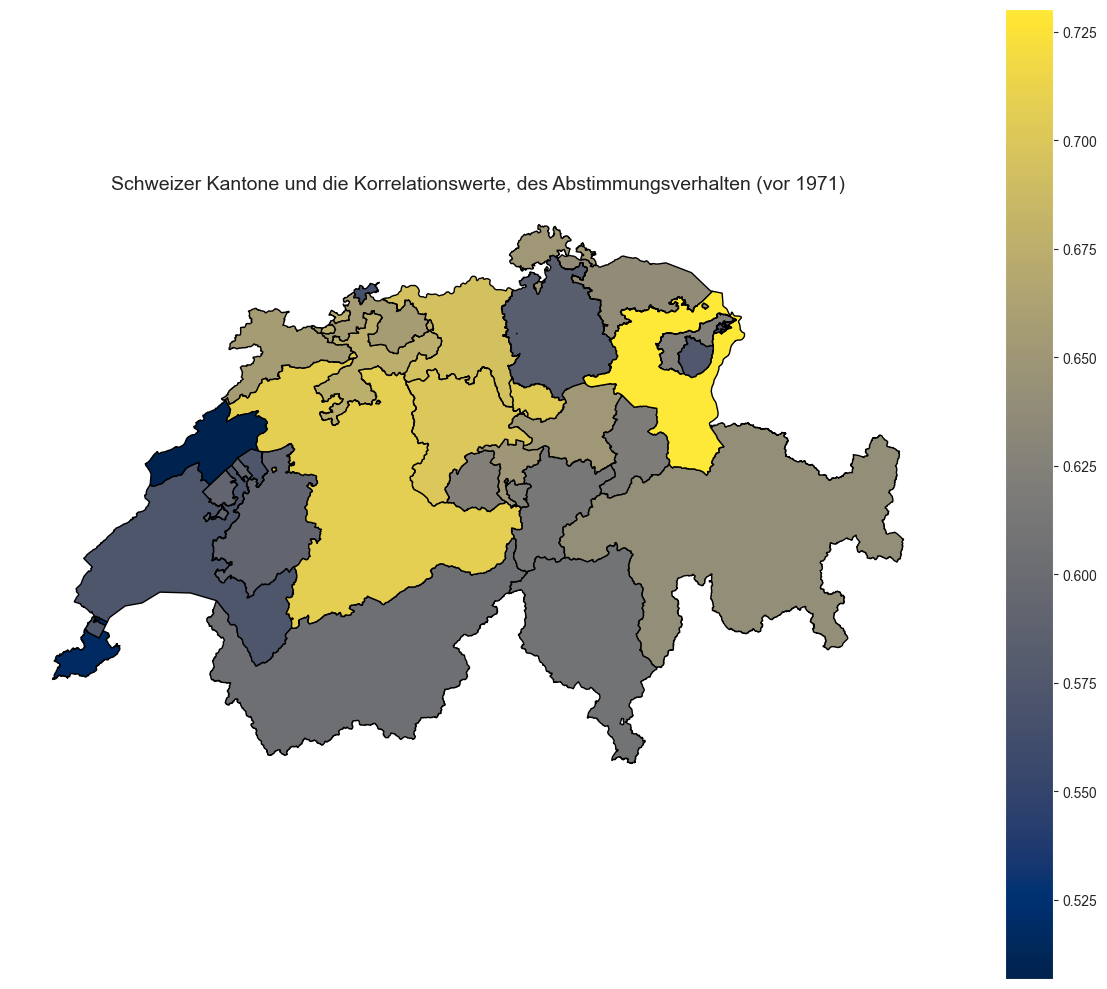

In [185]:
# Adjust size as needed (width, height in inches)
fig, ax = plt.subplots(figsize=(12, 10))

# Plot with reversed 'YlOrRd' colormap: more yellow = more populated
merged_shapes_before.plot(
    column='avg_corr',
    cmap='cividis',
    linewidth=1,
    edgecolor='black',
    legend=True,
    ax=ax
)

# Add title and remove axis
ax.set_title('Schweizer Kantone und die Korrelationswerte, des Abstimmungsverhalten (vor 1971)', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

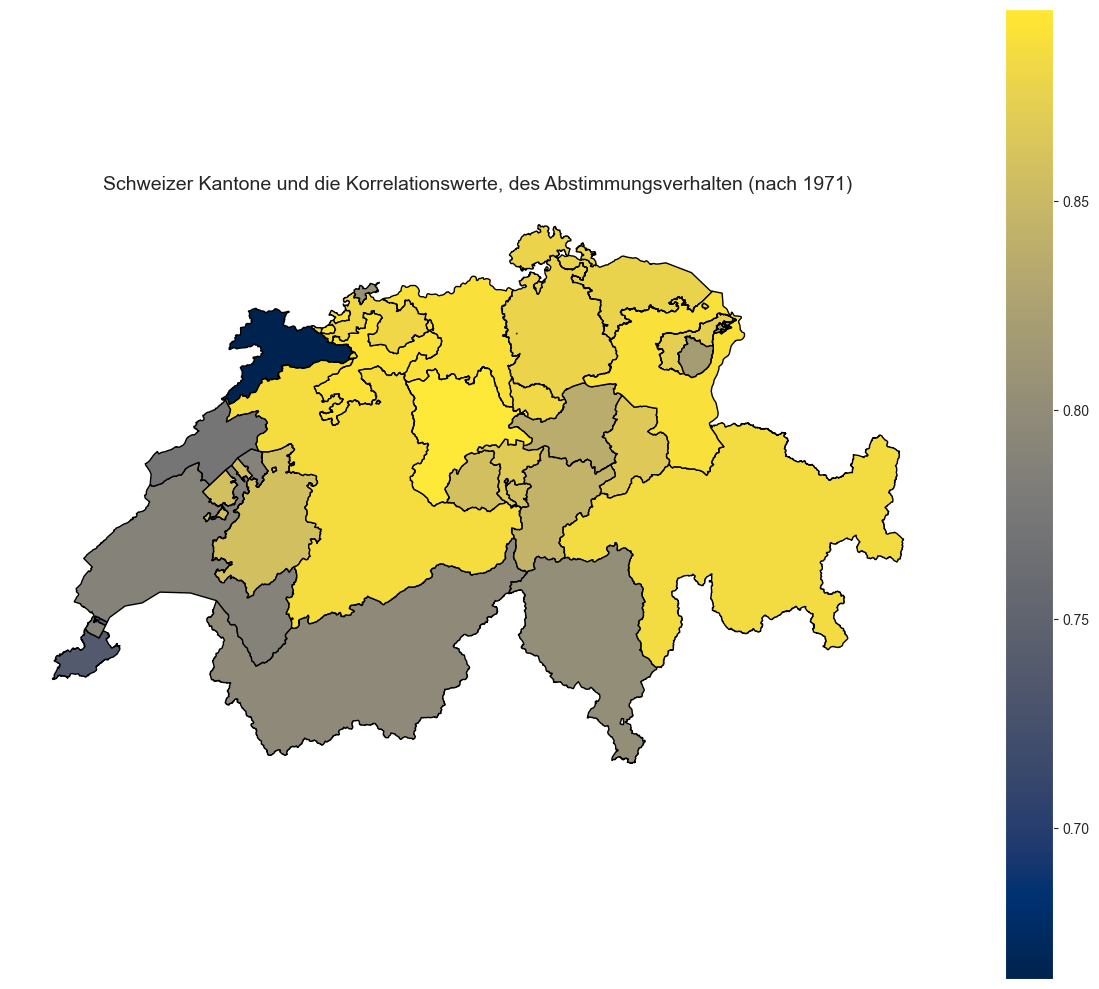

In [186]:
# Adjust size as needed (width, height in inches)
fig, ax = plt.subplots(figsize=(12, 10))

# Colormap for better visibility
merged_shapes_after.plot(
    column='avg_corr',
    cmap='cividis',
    linewidth=1,
    edgecolor='black',
    legend=True,
    ax=ax
)

# Add title and remove axis
ax.set_title('Schweizer Kantone und die Korrelationswerte, des Abstimmungsverhalten (nach 1971)', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

### Erkenntnisse:
Die Kantone scheinen nach der Abstimmung stärker zu korrelieren.
Ausserdem scheinen eher konservative Kantone wie Uri, Appenzell Innerrhoden und Schwyz sich angeglichen zu haben.
Zudem scheint sich Jura stark an der französischen Schweiz zu orientieren.

## 6. Erweiterte Analyse: Missing-Values-Heatmap

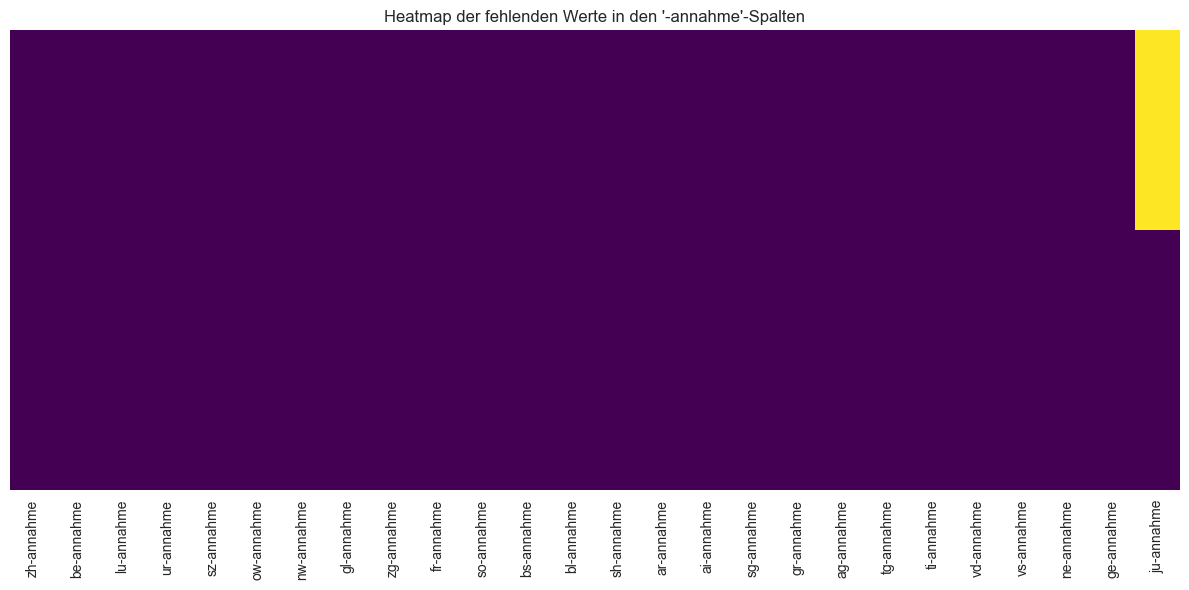

In [144]:
# Visualisiere fehlende Werte in den Abstimmungsdaten pro Kanton
plt.figure(figsize=(12, 6))
sns.heatmap(df_filtered.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Heatmap der fehlenden Werte in den '-annahme'-Spalten")
plt.tight_layout()
plt.show()

## 7. Analyse der Übereinstimmung zwischen Kantonsstimmen und den Positionen von Ständerat und Nationalrat

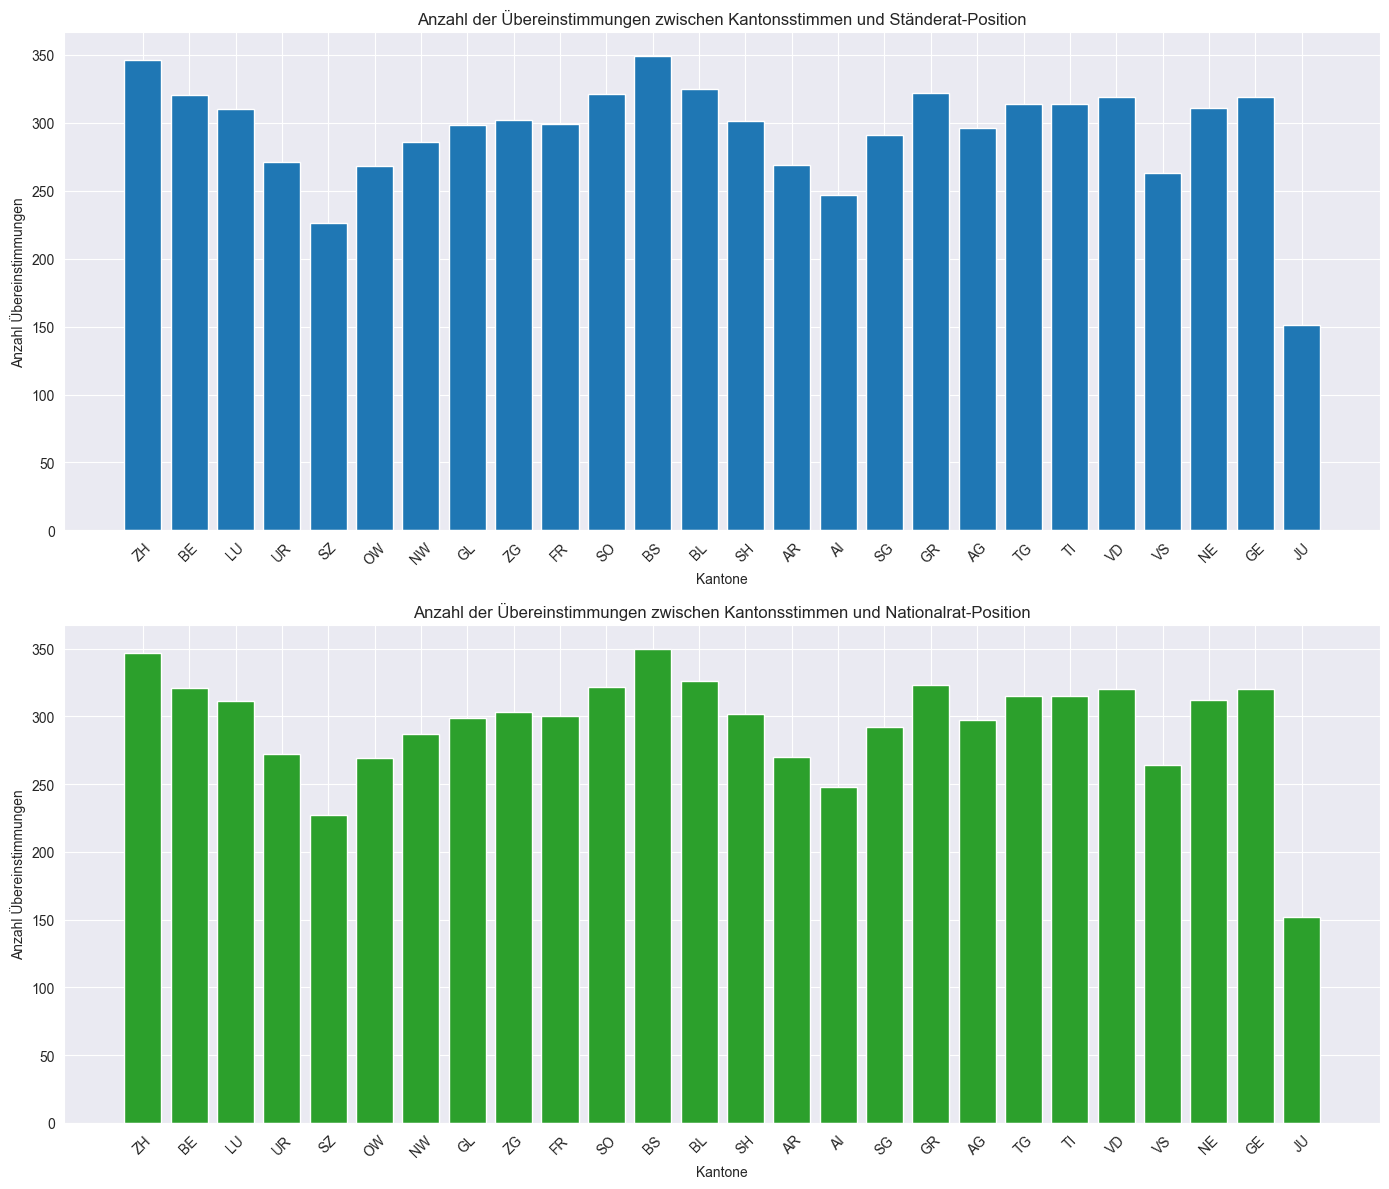

In [145]:
# -------------------------------
# 7. Analyse der Übereinstimmung zwischen Kantonsstimmen und den Positionen von Ständerat und Nationalrat
# -------------------------------

# Bereite die Spalten 'sr-pos' (Ständerat) und 'nr-pos' (Nationalrat) auf
# Wandle problematische Werte um und konvertiere in numerisches Format
df['sr-pos'] = df['sr-pos'].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
df['nr-pos'] = df['nr-pos'].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
df['sr-pos'] = pd.to_numeric(df['sr-pos'], errors='coerce')
df['nr-pos'] = pd.to_numeric(df['nr-pos'], errors='coerce')

# Selektiere alle Kantonsspalten für die Analyse
canton_columns = [col for col in df.columns if '-annahme' in col]

# Erstelle leere DataFrames zur Speicherung der Übereinstimmungen
sr_matches = pd.DataFrame(index=df.index)
nr_matches = pd.DataFrame(index=df.index)

# Vergleiche für jeden Kanton, ob dessen Abstimmung mit der Position von Ständerat und Nationalrat übereinstimmt
for canton in canton_columns:
    # Konvertiere die Kantonsstimme in numerisches Format
    canton_vote = pd.to_numeric(df[canton].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0}), errors='coerce')
    
    # Prüfe auf Übereinstimmung (True wenn die Stimme mit der Position übereinstimmt)
    sr_matches[canton] = (canton_vote == df['sr-pos'])
    nr_matches[canton] = (canton_vote == df['nr-pos'])

# Berechne die Anzahl der Übereinstimmungen pro Kanton
sr_match_counts = sr_matches.sum(axis=0)
nr_match_counts = nr_matches.sum(axis=0)

# Extrahiere die Kantonsnamen für die Darstellung
canton_names = [col.replace('-annahme', '').upper() for col in canton_columns]

# Erstelle Diagramme für die absolute Anzahl der Übereinstimmungen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Diagramm für Übereinstimmungen mit dem Ständerat
ax1.bar(canton_names, sr_match_counts.values, color='tab:blue')
ax1.set_title('Anzahl der Übereinstimmungen zwischen Kantonsstimmen und Ständerat-Position')
ax1.set_ylabel('Anzahl Übereinstimmungen')
ax1.set_xlabel('Kantone')
ax1.tick_params(axis='x', rotation=45)

# Diagramm für Übereinstimmungen mit dem Nationalrat
ax2.bar(canton_names, nr_match_counts.values, color='tab:green')
ax2.set_title('Anzahl der Übereinstimmungen zwischen Kantonsstimmen und Nationalrat-Position')
ax2.set_ylabel('Anzahl Übereinstimmungen')
ax2.set_xlabel('Kantone')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Berechnen und Plotten der Prozentualen Angaben

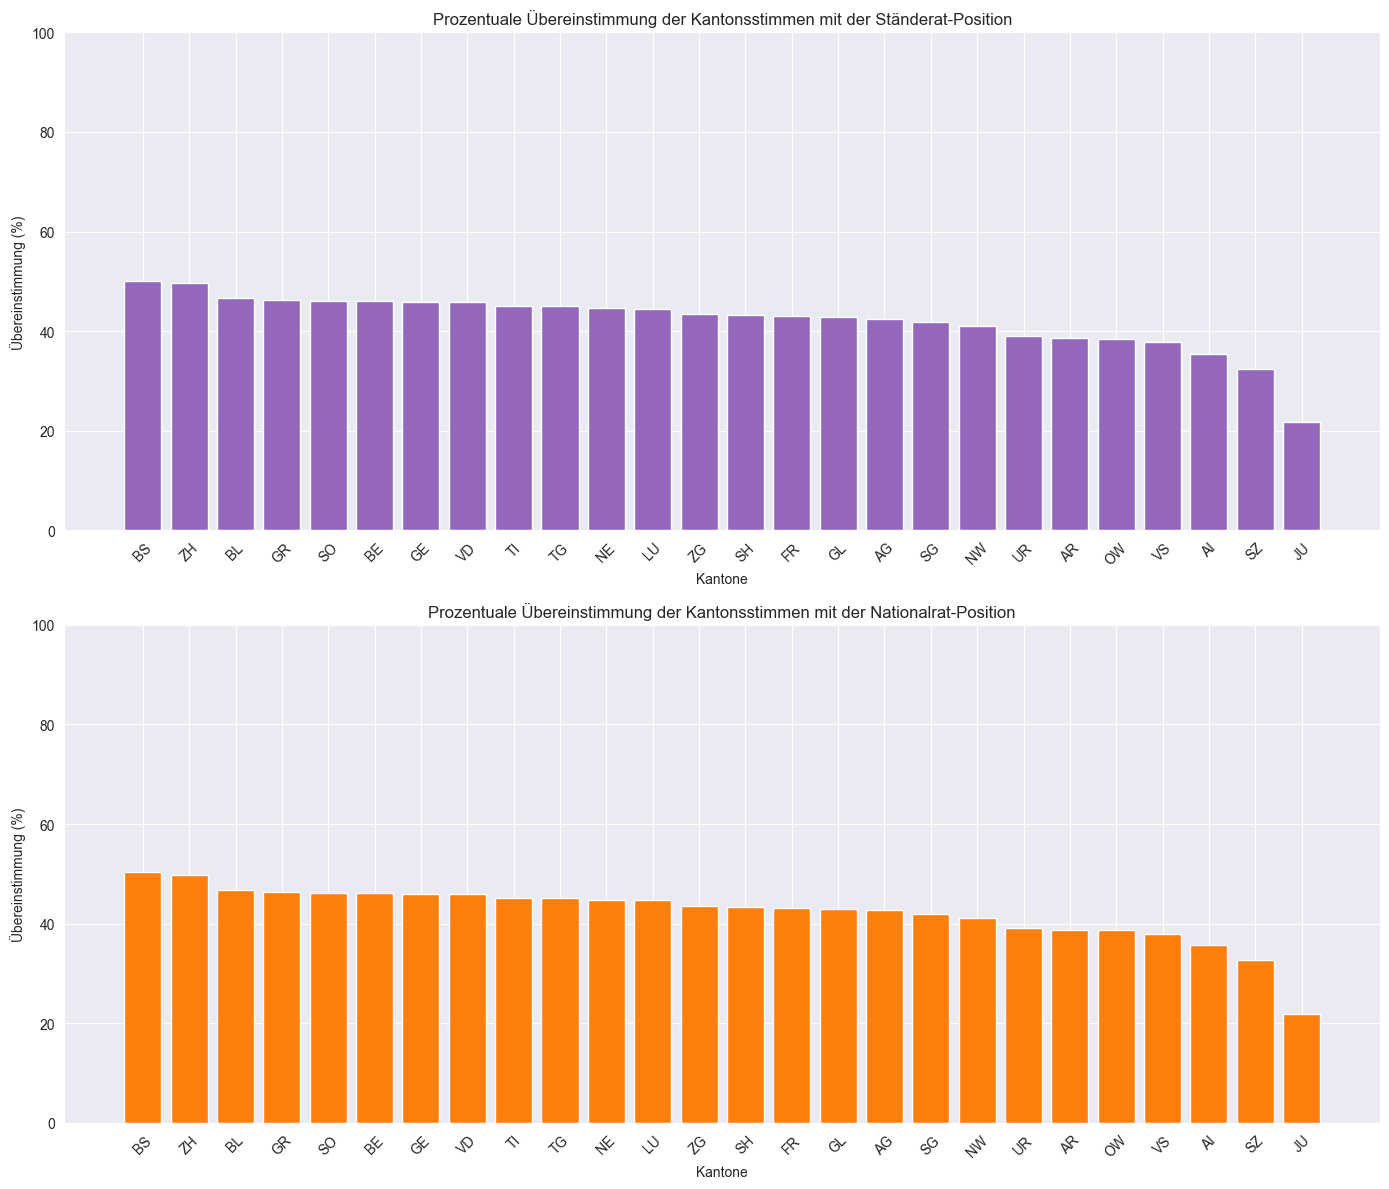

In [146]:
# Berechne den prozentualen Anteil der Übereinstimmungen
total_valid_votes = (~df['sr-pos'].isna()).sum()  # Anzahl gültiger Abstimmungen
sr_match_percentages = (sr_match_counts / total_valid_votes * 100).sort_values(ascending=False)  # Prozentsatz und absteigende Sortierung
nr_match_percentages = (nr_match_counts / total_valid_votes * 100).sort_values(ascending=False)  # Prozentsatz und absteigende Sortierung

# Erstelle Diagramme für die prozentualen Übereinstimmungen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Diagramm für prozentuale Übereinstimmungen mit dem Ständerat
ax1.bar(sr_match_percentages.index.str.replace('-annahme', '').str.upper(),
        sr_match_percentages.values, color='tab:purple')
ax1.set_title('Prozentuale Übereinstimmung der Kantonsstimmen mit der Ständerat-Position')
ax1.set_ylabel('Übereinstimmung (%)')
ax1.set_xlabel('Kantone')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 100)  # Y-Achse von 0 bis 100%

# Diagramm für prozentuale Übereinstimmungen mit dem Nationalrat
ax2.bar(nr_match_percentages.index.str.replace('-annahme', '').str.upper(),
        nr_match_percentages.values, color='tab:orange')
ax2.set_title('Prozentuale Übereinstimmung der Kantonsstimmen mit der Nationalrat-Position')
ax2.set_ylabel('Übereinstimmung (%)')
ax2.set_xlabel('Kantone')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100)  # Y-Achse von 0 bis 100%

plt.tight_layout()
plt.show()